In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import folium
from folium.plugins import MarkerCluster
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from shapely.geometry import Point
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import requests
import pymannkendall as mk
from tqdm import tqdm

# Setting the path for convenience
data_dir_fk = os.path.expanduser("~/multitressor/CREMP_CSV_Files")
data_dir_dt = os.path.expanduser("~/multitressor/DTCREMP_CSV_Files")
print(f"Environment ready. Data directory set to: {data_dir_fk}")

Environment ready. Data directory set to: /home/enrique.montes@CNS.local/multitressor/CREMP_CSV_Files


#### Load data and render map showing location of CREMP monitoring sites

In [2]:
# 1. Load the dataset
stations_path_fk = os.path.join(data_dir_fk, "CREMP_Stations_2024.csv")
stations_path_dt = os.path.join(data_dir_dt, "DTCREMP_Stations_2024.csv")
df_stations_fk = pd.read_csv(stations_path_fk)
df_stations_dt = pd.read_csv(stations_path_dt)
df_stations = pd.concat([df_stations_fk, df_stations_dt], ignore_index=True)

# 2. Initialize the map with Satellite Imagery
# We use Esri.WorldImagery for the satellite background
m = folium.Map(
    location=[24.8, -80.8], 
    zoom_start=8, 
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite'
)

# 3. Add stations to the map
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_stations.iterrows():
    if pd.notnull(row['latDD']) and pd.notnull(row['lonDD']):
        # Popup string formatted as a list-style block
        popup_text = f"""
        Station: {row.get('Site_name', 'N/A')}
        <br>ID: {row.get('StationID', 'N/A')}
        <br>Habitat: {row.get('Habitat', 'N/A')}
        <br>First Surveyed: {row.get('First_Year_surveyed', 'N/A')}
        <br>Depth: {row.get('Depth_ft', 'N/A')} ft
        """
        
        folium.Marker(
            location=[row['latDD'], row['lonDD']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row.get('Site_name', 'Click for info')
        ).add_to(marker_cluster)

# Display the map
m

#### Benthic trend analysis and mapping

Linear Trend Analysis (Total Stony Coral Cover):


,SiteName,Slope,P_Value
29,Palmata Patch,0.001959,0.058564
48,Turtle,0.000477,0.159845
24,Mayer's Peak,0.000374,0.219726
50,West Turtle Shoal,0.000208,0.554128
13,Dove Key,0.000013,0.902454
32,Rattlesnake,-0.000043,0.796175
17,El Radabob,-0.000051,0.255487
26,Molasses Keys,-0.000054,0.205656
25,Molasses Deep,-0.000082,0.709174
42,Temptation Rock,-0.000090,0.827335


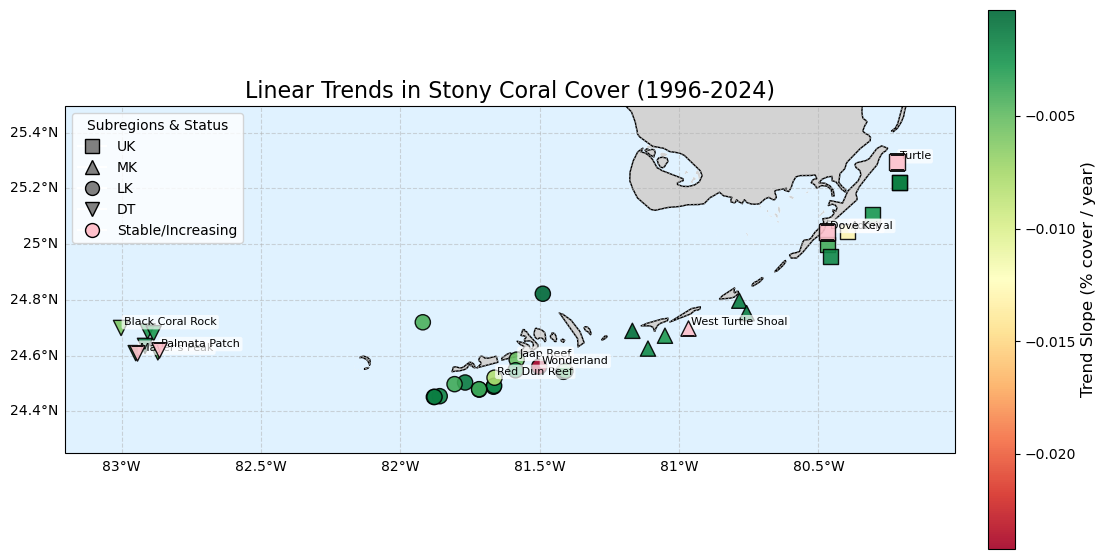


Trend Statistics per Subregion:


/tmp/ipykernel_1207842/1723426217.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_box = sns.boxplot(


,count,mean,std,min,25%,50%,75%,max
Subregion,,,,,,,,
DT,11.0,-0.0017,0.0023,-0.0059,-0.0030,-0.0007,-0.0002,0.0020
LK,18.0,-0.0037,0.0055,-0.0242,-0.0039,-0.0018,-0.0011,-0.0003
MK,13.0,-0.0009,0.0010,-0.0029,-0.0014,-0.0007,-0.0002,0.0002
UK,15.0,-0.0018,0.0034,-0.0130,-0.0017,-0.0002,-0.0001,0.0005


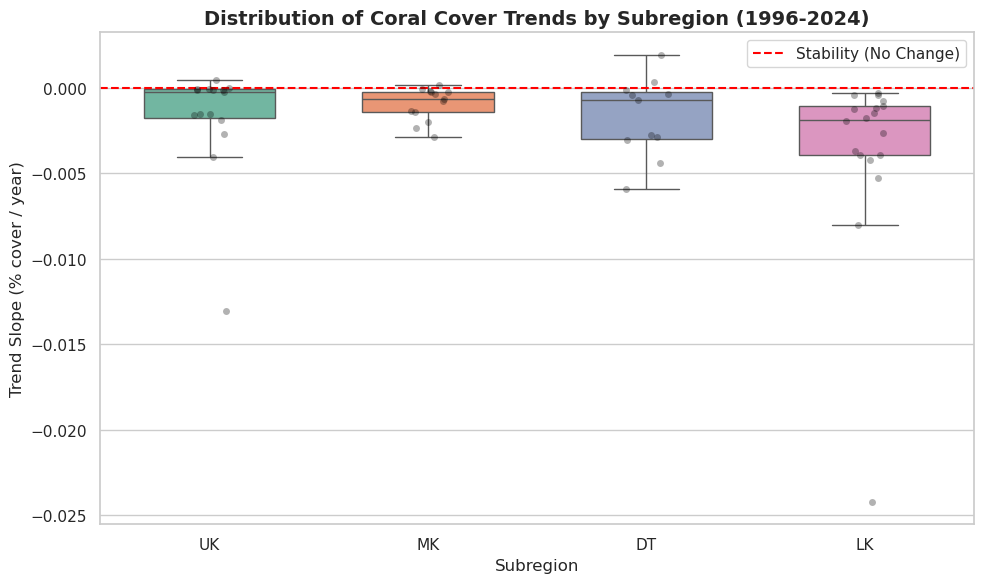

In [3]:
# Load data 
pcover_path_fk = os.path.join(data_dir_fk, "CREMP_Pcover_StonyCoralSpecies_2024.csv")
pcover_path_dt = os.path.join(data_dir_dt, "DTCREMP_Pcover_StonyCoralSpecies_2024.csv")
df_pcover_fk = pd.read_csv(pcover_path_fk)
df_pcover_dt = pd.read_csv(pcover_path_dt)
df_pcover = pd.concat([df_pcover_fk, df_pcover_dt], ignore_index=True)

# Calculate total stony coral cover per site per year
species_cols = df_pcover.columns[11:] 
df_pcover['Total_Cover'] = df_pcover[species_cols].sum(axis=1)
site_annual = df_pcover.groupby(['SiteName', 'SampleYear'])['Total_Cover'].mean().reset_index()

stats_list = []
for site in site_annual['SiteName'].unique():
    site_data = site_annual[site_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data['Total_Cover'])
        stats_list.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_trends = pd.DataFrame(stats_list)

# Display the trend table
print("Linear Trend Analysis (Total Stony Coral Cover):")
display(df_trends.sort_values('Slope', ascending=False).head(10)) 

# --- MERGE ONCE TO AVOID DUPLICATE COLUMNS (_x, _y) ---
# We extract all metadata (coords + subregion) in one clean dataframe
df_coords_master = df_stations[['Site_name', 'latDD', 'lonDD', 'Subregion']].drop_duplicates(subset='Site_name')

# Merge trends with coordinates and subregions exactly once
df_map_data = pd.merge(df_trends, df_coords_master, left_on='SiteName', right_on='Site_name')

# Define the marker mapping dictionary
marker_map = {
    'UK': 's',  # Square
    'MK': '^',  # Triangle up
    'LK': 'o',  # Circle
    'DT': 'v'   # Triangle down
}

# --- DERIVE SUBSETS FROM THE FULLY MERGED DATAFRAME ---
# This ensures df_significant and df_pos inherit 'Subregion', 'lonDD', and 'latDD'
df_significant = df_map_data[df_map_data['P_Value'] < 0.05].copy()
df_pos = df_map_data[df_map_data['Slope'] >= 0].copy()

# Setup the figure with a PlateCarree projection
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add high-resolution geographic features
# '10m' provides the highest resolution for coastal details
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# loop through the marker map to plot each subregion with its specific symbol
sc = None # Placeholder for colorbar reference

for sub, mkr in marker_map.items():
    # Filter for significant sites in this subregion
    sub_sig = df_significant[df_significant['Subregion'] == sub]
    if not sub_sig.empty:
        sc = ax.scatter(sub_sig['lonDD'], sub_sig['latDD'], 
                        c=sub_sig['Slope'], cmap='RdYlGn', marker=mkr,
                        s=120, edgecolor='black', alpha=0.9, 
                        transform=ccrs.PlateCarree(), zorder=3,
                        vmin=df_significant['Slope'].min(), vmax=df_significant['Slope'].max())

    # Filter for stable/increasing sites in this subregion
    sub_pos = df_pos[df_pos['Subregion'] == sub]
    if not sub_pos.empty:
        ax.scatter(sub_pos['lonDD'], sub_pos['latDD'], 
                   color='pink', marker=mkr,
                   s=120, edgecolor='black', alpha=0.9, 
                   transform=ccrs.PlateCarree(), zorder=4)

# Set the map extent to focus on the Florida Keys / study area
# [min_lon, max_lon, min_lat, max_lat]
ax.set_extent([df_map_data['lonDD'].min() - 0.2, df_map_data['lonDD'].max() + 0.2,
               df_map_data['latDD'].min() - 0.2, df_map_data['latDD'].max() + 0.2], 
              crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('Trend Slope (% cover / year)', fontsize=12)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, zorder=2)
gl.top_labels = False
gl.right_labels = False

# Labels for significant sites (p < 0.05)
for idx, row in df_map_data.iterrows():
    if row['Slope'] <= -0.005 or row['Slope'] >= 0:
        ax.text(row['lonDD'] + 0.01, row['latDD'] + 0.01, row['SiteName'],
                fontsize=8, transform=ccrs.PlateCarree(),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none'))

# Create a manual legend to explain the subregions and pink markers
legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                          markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                   for k, m in marker_map.items()]
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Stable/Increasing',
                               markerfacecolor='pink', markersize=10, markeredgecolor='k'))

ax.legend(handles=legend_elements, loc='upper left', title="Subregions & Status", frameon=True)

plt.title('Linear Trends in Stony Coral Cover (1996-2024)', fontsize=16)
plt.show()

# Create a separate figure for the box plot distribution analysis
plt.figure(figsize=(10, 6))

# Set a clean theme
sns.set_theme(style="whitegrid")

# Create the boxplot
# Note: Using df_map_data to include all sites, not just significant ones, 
# to show the true regional distribution.
ax_box = sns.boxplot(
    data=df_map_data, 
    x='Subregion', 
    y='Slope', 
    palette='Set2', 
    showfliers=False,  # Hides outliers to focus on the main distribution
    width=0.6
)

# Overlay individual site points (stripplot) to see the sample size and spread
sns.stripplot(
    data=df_map_data, 
    x='Subregion', 
    y='Slope', 
    color='black', 
    alpha=0.3, 
    jitter=True
)

# Add a horizontal line at 0 for reference (Stability line)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Stability (No Change)')

# Formatting
plt.title('Distribution of Coral Cover Trends by Subregion (1996-2024)', fontsize=14, fontweight='bold')
plt.ylabel('Trend Slope (% cover / year)', fontsize=12)
plt.xlabel('Subregion', fontsize=12)
plt.legend()

# Show statistics summary
print("\nTrend Statistics per Subregion:")
display(df_map_data.groupby('Subregion')['Slope'].describe().round(4))

plt.tight_layout()
plt.show()

#### Species-level trend analysis

Species-Level Trend Analysis (All Sites Integrated):


,Species,Slope,P_Value,R_Squared
44,Total_Cover,-9.542411e-04,8.898706e-05,4.394769e-01
30,Orbicella_annularis_complex,-9.402700e-04,8.498909e-15,8.960874e-01
0,Acropora_palmata,-1.602639e-04,7.670165e-04,3.473965e-01
22,Millepora_complanata,-1.226721e-04,1.816419e-03,3.070220e-01
23,Montastraea_cavernosa,-1.128343e-04,7.059334e-03,2.394499e-01
36,Scleractinia,-9.438072e-05,2.413322e-05,4.893484e-01
8,Colpophyllia_natans,-4.841473e-05,3.206312e-01,3.652883e-02
9,Dendrogyra_cylindrus,-4.625771e-05,4.152204e-12,8.360099e-01
35,Pseudodiploria_strigosa,-3.398927e-05,4.552375e-04,3.708456e-01
11,Diploria_labyrinthiformis,-2.285889e-05,5.795284e-07,6.097877e-01


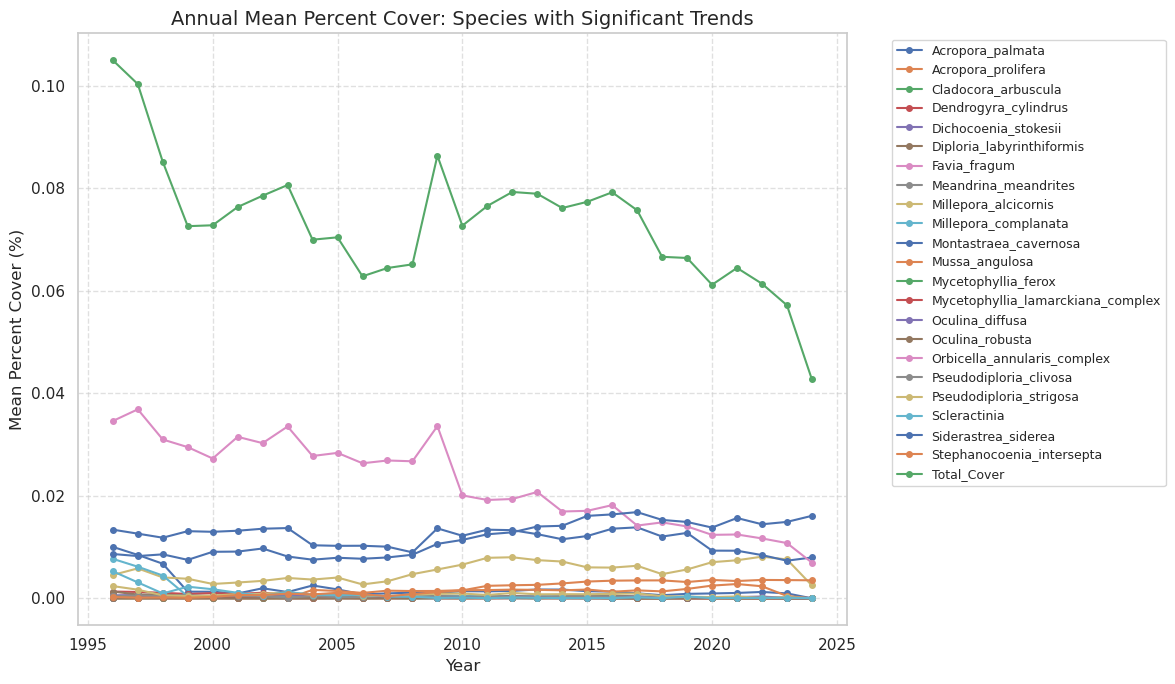

In [5]:
# Identify species columns (from index 11 onwards)
species_list = df_pcover.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every species across all sites per year
species_annual = df_pcover.groupby('SampleYear')[species_list].mean().reset_index()

# Calculate Linear Trends for each species
species_stats = []

for species in species_list:
    # Remove years where the species might have zero data if necessary. 
    y = species_annual[species]
    x = species_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    species_stats.append({
        'Species': species,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_species_trends = pd.DataFrame(species_stats)

# Identify significant species (p < 0.05)
significant_species = df_species_trends[df_species_trends['P_Value'] < 0.05].copy()

print("Species-Level Trend Analysis (All Sites Integrated):")
display(df_species_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Species Only
if not significant_species.empty:
    plt.figure(figsize=(12, 7))
    
    for species in significant_species['Species']:
        plt.plot(species_annual['SampleYear'], species_annual[species], 
                 marker='o', markersize=4, label=f"{species}")

    plt.title('Annual Mean Percent Cover: Species with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")

#### Check stations where a selected SPECIES shows a significant (p < 0.05) trend

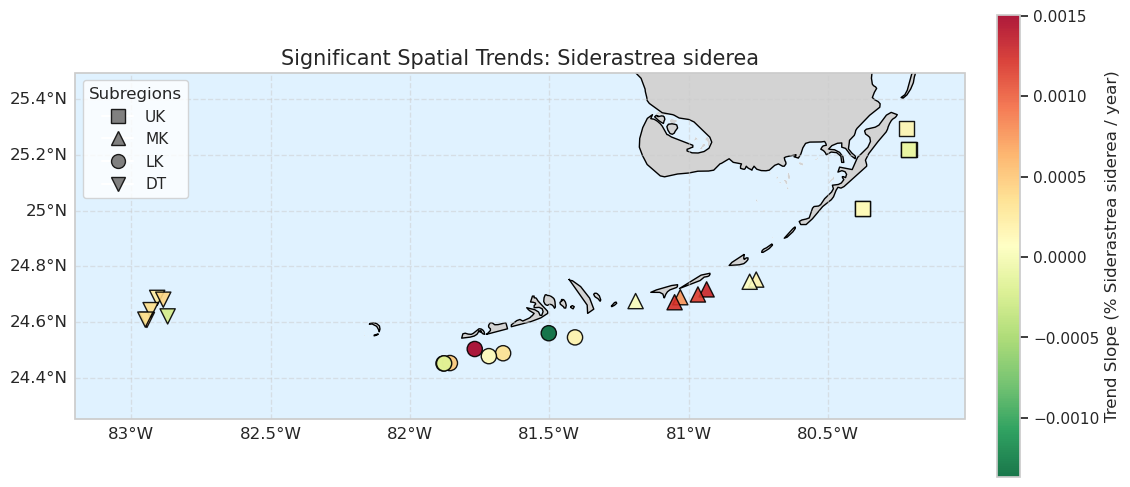

/tmp/ipykernel_1207842/2628268644.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_species_map, x='Subregion', y='Slope', palette='Set2', showfliers=False)


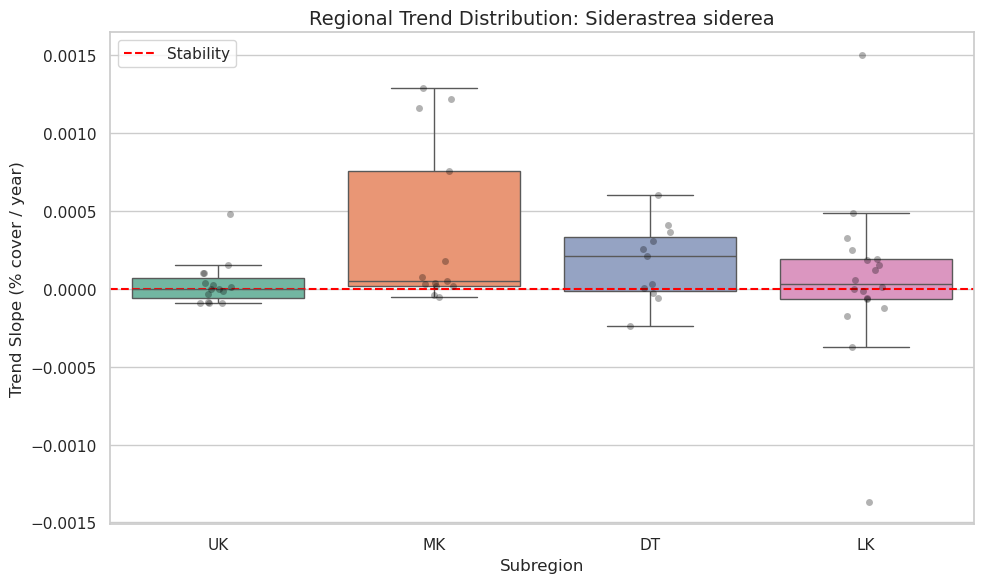

In [7]:
# --- 1. PREPARE COORDINATES ---
# Re-extract site metadata from df_stations
df_coords = df_stations[['Site_name', 'latDD', 'lonDD', 'Subregion']].drop_duplicates(subset='Site_name')

# --- Spatial Analysis for a Selected Species ---
selected_species = 'Siderastrea_siderea'

# Group by Site and Year for the specific species
site_species_annual = df_pcover.groupby(['SiteName', 'SampleYear'])[selected_species].mean().reset_index()

# Calculate trends for this species at each individual site
site_species_stats = []
for site in site_annual['SiteName'].unique():
    site_data = site_species_annual[site_species_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_species])
        site_species_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_species_map = pd.DataFrame(site_species_stats)

# Merge with coordinates (df_coords already contains 'Subregion' from our previous fix)
df_species_map = pd.merge(df_species_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_species_map[df_species_map['P_Value'] < 0.05].copy()

# Render the Map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# --- SYMBOL MAPPING LOGIC ---
marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}
sc = None

for sub, mkr in marker_map.items():
    sub_sig = df_sig_map[df_sig_map['Subregion'] == sub]
    if not sub_sig.empty:
        sc = ax.scatter(sub_sig['lonDD'], sub_sig['latDD'], 
                        c=sub_sig['Slope'], cmap='RdYlGn_r', marker=mkr,
                        s=120, edgecolor='black', alpha=0.9, 
                        transform=ccrs.PlateCarree(), zorder=3,
                        vmin=df_sig_map['Slope'].min(), vmax=df_sig_map['Slope'].max())

# Add Colorbar
if sc:
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
    cbar.set_label(f'Trend Slope (% {selected_species.replace("_", " ")} / year)')

# Custom Legend for Subregions (Outside map)
legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                          markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                   for k, m in marker_map.items()]

ax.legend(handles=legend_elements, loc='upper left', title="Subregions", frameon=True)

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_species.replace("_", " ")}', fontsize=15)
plt.show()

# --- NEW: BOXPLOT FOR SPECIES TREND DISTRIBUTION ---
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=df_species_map, x='Subregion', y='Slope', palette='Set2', showfliers=False)
sns.stripplot(data=df_species_map, x='Subregion', y='Slope', color='black', alpha=0.3, jitter=True)

plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Stability')
plt.title(f'Regional Trend Distribution: {selected_species.replace("_", " ")}', fontsize=14)
plt.ylabel('Trend Slope (% cover / year)')
plt.legend()
plt.tight_layout()
plt.show()

#### Check stations where a selected TAXONOMIC GROUP shows a significant (p < 0.05) trend

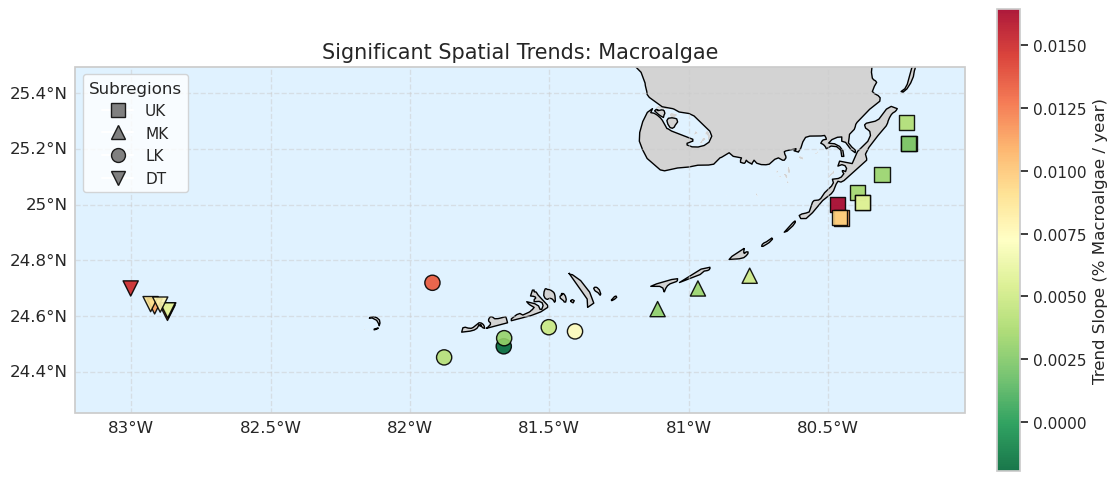

/tmp/ipykernel_1207842/1302580294.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_taxa_map, x='Subregion', y='Slope', palette='Set2', showfliers=False)


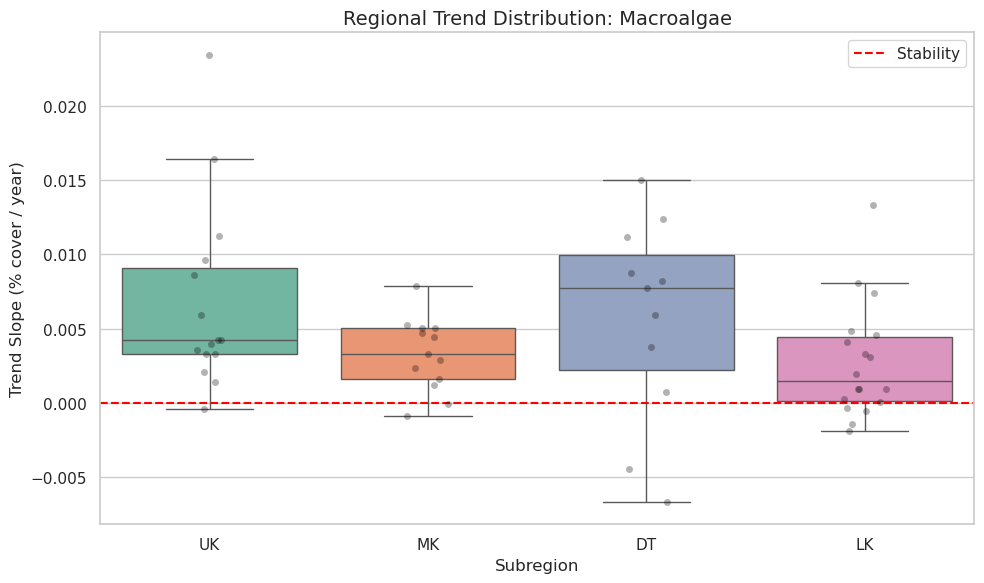

In [8]:
# --- 1. Data Loading (Taxa Groups) ---
taxagroups_path_fk = os.path.join(data_dir_fk, "CREMP_Pcover_TaxaGroups_2024.csv")
taxagroups_path_dt = os.path.join(data_dir_dt, "DTCREMP_Pcover_TaxaGroups_2024.csv")
df_taxagroups_fk = pd.read_csv(taxagroups_path_fk)
df_taxagroups_dt = pd.read_csv(taxagroups_path_dt)
df_taxagroups = pd.concat([df_taxagroups_fk, df_taxagroups_dt], ignore_index=True)

# --- 2. Spatial Analysis for a Selected Group ---
selected_group = 'Macroalgae'

# Group by Site and Year for the specific group
site_taxa_annual = df_taxagroups.groupby(['SiteName', 'SampleYear'])[selected_group].mean().reset_index()

# Calculate trends for this group at each individual site
site_taxa_stats = []
for site in site_taxa_annual['SiteName'].unique():
    site_data = site_taxa_annual[site_taxa_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_group])
        site_taxa_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_taxa_map = pd.DataFrame(site_taxa_stats)

# Merge with coordinates (df_coords includes 'Subregion')
df_taxa_map = pd.merge(df_taxa_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_taxa_map[df_taxa_map['P_Value'] < 0.05].copy()

# --- 3. Render the Map ---
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# --- 4. SYMBOL MAPPING LOGIC (UK, MK, LK, DT) ---
marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}
sc = None

# Plot Trends using unique symbols per subregion
for sub, mkr in marker_map.items():
    sub_sig = df_sig_map[df_sig_map['Subregion'] == sub]
    if not sub_sig.empty:
        # Note: We use RdYlGn_r because increasing Macroalgae is often 
        # considered a negative ecological indicator (Red = Increasing)
        sc = ax.scatter(sub_sig['lonDD'], sub_sig['latDD'], 
                        c=sub_sig['Slope'], cmap='RdYlGn_r', marker=mkr,
                        s=120, edgecolor='black', alpha=0.9, 
                        transform=ccrs.PlateCarree(), zorder=3,
                        vmin=df_sig_map['Slope'].min(), vmax=df_sig_map['Slope'].max())

# Add Colorbar
if sc:
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
    cbar.set_label(f'Trend Slope (% {selected_group} / year)')

# Custom Legend for Subregions (Placed Outside Map)
legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                          markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                   for k, m in marker_map.items()]
ax.legend(handles=legend_elements, loc='upper left', title="Subregions", frameon=True)

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_group.replace("_", " ")}', fontsize=15)
plt.show()

# --- 5. BOXPLOT FOR TAXA TREND DISTRIBUTION ---
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create boxplot of all trends (significant and non-significant)
sns.boxplot(data=df_taxa_map, x='Subregion', y='Slope', palette='Set2', showfliers=False)
sns.stripplot(data=df_taxa_map, x='Subregion', y='Slope', color='black', alpha=0.3, jitter=True)

plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Stability')
plt.title(f'Regional Trend Distribution: {selected_group.replace("_", " ")}', fontsize=14)
plt.ylabel('Trend Slope (% cover / year)')
plt.legend()
plt.tight_layout()
plt.show()

#### Plot time series of taxa groups

Taxa-Level Trend Analysis (All Sites Integrated):


,Taxa,Slope,P_Value,R_Squared
6,Substrate,-0.005758,0.000022,0.492548
5,StonyCoral,-0.000997,0.000063,0.453045
4,Seagrass,-0.000218,0.000003,0.564022
2,Others,0.000100,0.000685,0.352515
9,Zoanthidea,0.000175,0.000211,0.404159
1,Octocoral,0.000735,0.049627,0.135303
3,Porifera,0.000839,0.000006,0.539026
0,Macroalgae,0.003885,0.000040,0.470590
7,Unknown,NaN,NaN,NaN
8,Urchins,NaN,NaN,NaN


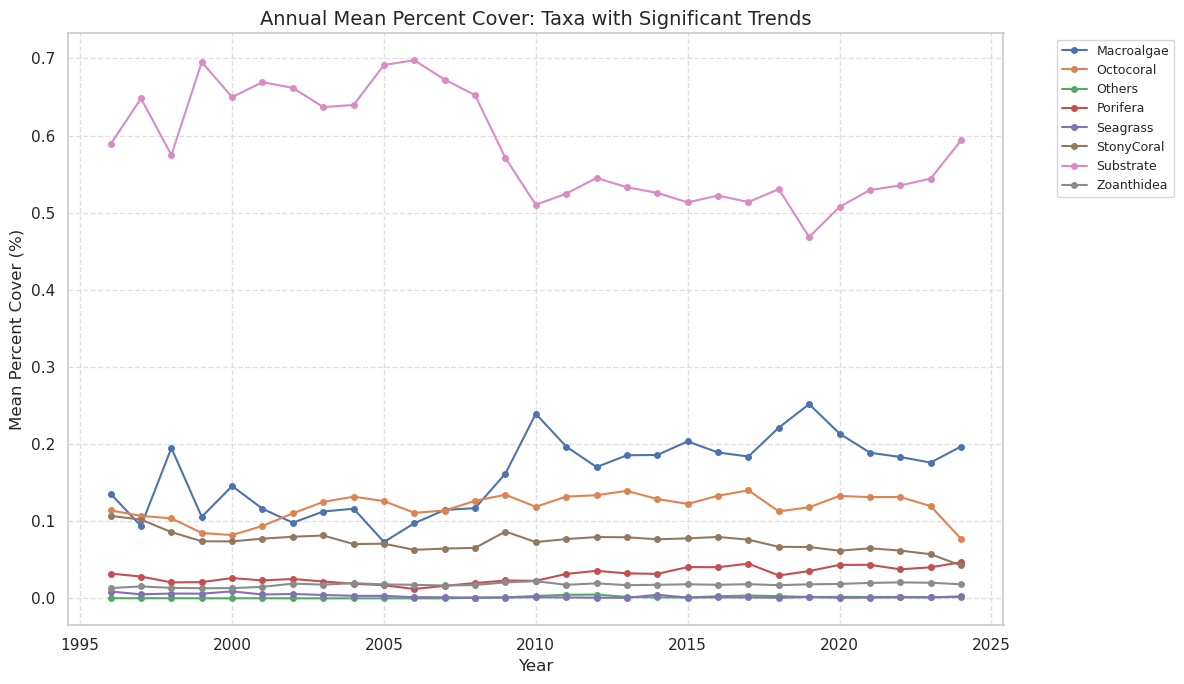

In [9]:
# Identify taxa columns (from index 11 onwards)
taxa_list = df_taxagroups.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every taxa across all sites per year
taxa_annual = df_taxagroups.groupby('SampleYear')[taxa_list].mean().reset_index()
# Calculate Linear Trends for each taxa
taxa_stats = []

for taxa in taxa_list:
    # Remove years where the taxa might have zero data if necessary. 
    y = taxa_annual[taxa]
    x = taxa_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    taxa_stats.append({
        'Taxa': taxa,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_taxa_trends = pd.DataFrame(taxa_stats)

# Identify significant taxa (p < 0.05)
significant_taxa = df_taxa_trends[df_taxa_trends['P_Value'] < 0.05].copy()
# significant_taxa = df_taxa_trends

print("Taxa-Level Trend Analysis (All Sites Integrated):")
display(df_taxa_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Taxa Only (Excluding Substrate)
if not significant_taxa.empty:
    plt.figure(figsize=(12, 7))

    for taxa in significant_taxa['Taxa']:
        # --- Skip 'Substrate' ---
        if taxa == '':
            continue
            
        plt.plot(taxa_annual['SampleYear'], taxa_annual[taxa], 
                 marker='o', markersize=4, label=f"{taxa}")

    plt.title('Annual Mean Percent Cover: Taxa with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    
    # The legend will now automatically exclude Substrate because it was never plotted
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")

#### First versus last-year comparison with boxplot

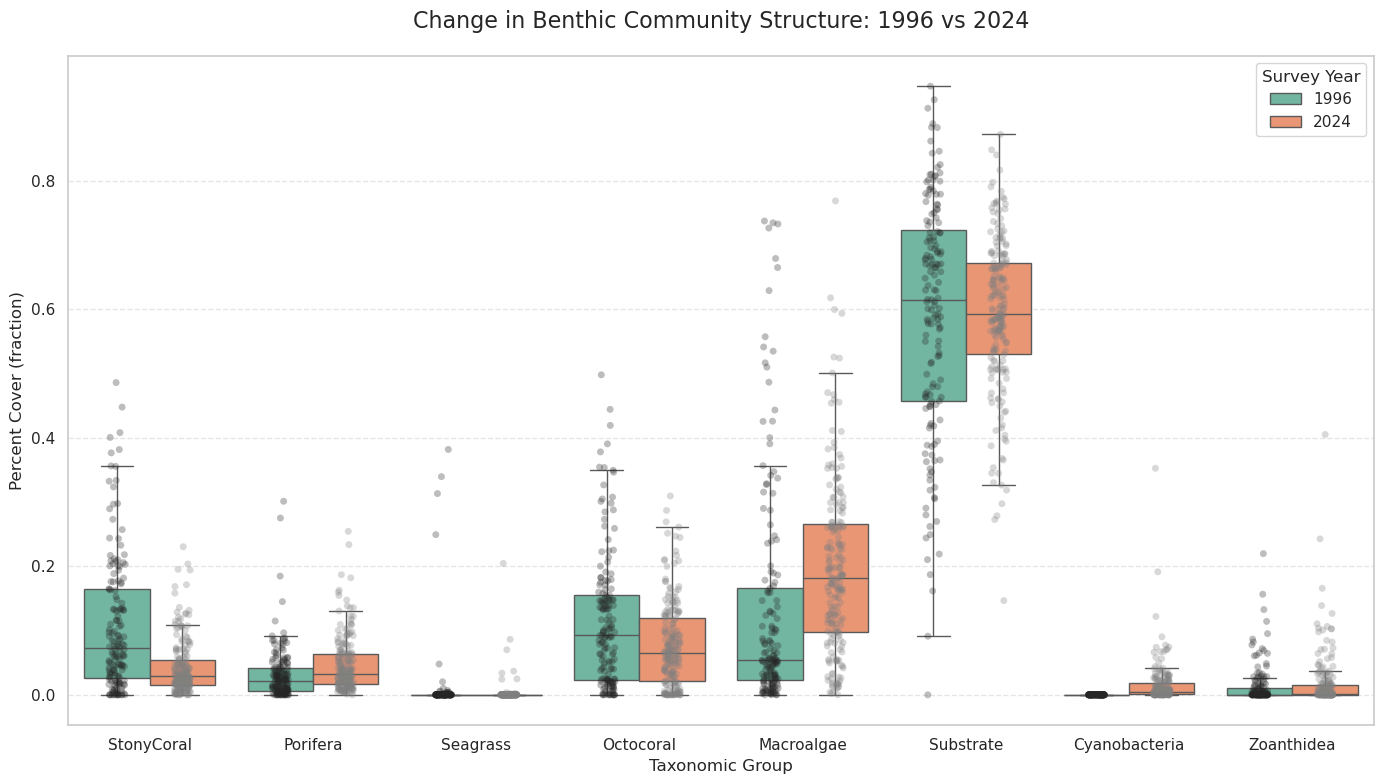

In [10]:
# Identify the first and last year of the time series
first_year = df_taxagroups['SampleYear'].min()
last_year = df_taxagroups['SampleYear'].max()

# Filter the dataset for these two years only
df_comparison = df_taxagroups[df_taxagroups['SampleYear'].isin([first_year, last_year])]

# Define the categories for the plot
categories = ['StonyCoral', 'Porifera', 'Seagrass', 'Octocoral', 'Macroalgae', 'Substrate', 'Cyanobacteria', 'Zoanthidea']

# Reshape data from 'wide' to 'long' format for Seaborn
df_melted = df_comparison.melt(
    id_vars=['SampleYear'], 
    value_vars=categories, 
    var_name='Category', 
    value_name='PercentCover'
)

# Render the Box-and-Whiskers plot
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_melted, 
    x='Category', 
    y='PercentCover', 
    hue='SampleYear', 
    palette='Set2',
    showfliers=False  # Optional: hides outliers for a cleaner look at the distributions
)

# Add jittered points to show the raw station data (optional)
sns.stripplot(
    data=df_melted, 
    x='Category', 
    y='PercentCover', 
    hue='SampleYear', 
    dodge=True, 
    alpha=0.3, 
    palette='dark:grey',
    legend=False
)

# Formatting for presentation
plt.title(f'Change in Benthic Community Structure: {first_year} vs {last_year}', fontsize=16, pad=20)
plt.ylabel('Percent Cover (fraction)', fontsize=12)
plt.xlabel('Taxonomic Group', fontsize=12)
plt.legend(title='Survey Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Percentile-based baseline and scoring table for the reef-EBQI index

In [11]:
# Use the entire dataset as the baseline (instead of just 1996)
df_baseline = df_taxagroups.copy()

# Define our target categories
pos_indicators = ['StonyCoral', 'Seagrass', 'Octocoral']
neg_indicators = ['Macroalgae', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
all_indicators = pos_indicators + neg_indicators

# Calculate percentiles (20th, 40th, 60th, 80th) across the whole time series
percentiles = [0.2, 0.4, 0.6, 0.8]
baseline_stats = df_baseline[all_indicators].quantile(percentiles).T
baseline_stats.columns = ['20th', '40th', '60th', '80th']

# Create the S-Score reference table with inclusive logic
s_score_table = []

for category in all_indicators:
    p20 = baseline_stats.loc[category, '20th']
    p40 = baseline_stats.loc[category, '40th']
    p60 = baseline_stats.loc[category, '60th']
    p80 = baseline_stats.loc[category, '80th']
    
    if category in pos_indicators:
        s_score_table.append({
            'Category': category,
            'Type': 'Positive (Higher is Better)',
            'S=0 (<20th)': f"< {p20:.4f}",
            'S=1 (20-40th)': f"{p20:.4f} - {p40:.4f}",
            'S=2 (40-60th)': f"{p40:.4f} - {p60:.4f}",
            'S=3 (60-80th)': f"{p60:.4f} - {p80:.4f}",
            'S=4 (>80th)': f"> {p80:.4f}"
        })
    else:
        # --- Using <= logic to handle cases where thresholds are 0 ---
        # This ensures that a value of 0 (absence of stressor) always gets the highest score.
        s_score_table.append({
            'Category': category,
            'Type': 'Negative (Lower is Better)',
            'S=4 (<=20th)': f"<= {p20:.4f}", # Changed < to <=
            'S=3 (20-40th)': f"{p20:.4f} - {p40:.4f}",
            'S=2 (40-60th)': f"{p40:.4f} - {p60:.4f}",
            'S=1 (60-80th)': f"{p60:.4f} - {p80:.4f}",
            'S=0 (>80th)': f"> {p80:.4f}"
        })

df_s_ref = pd.DataFrame(s_score_table)

print("reef-EBQI S-Score Thresholds (Based on Entire Time Series):")
display(df_s_ref)

reef-EBQI S-Score Thresholds (Based on Entire Time Series):


,Category,Type,S=0 (<20th),S=1 (20-40th),S=2 (40-60th),S=3 (60-80th),S=4 (>80th),S=4 (<=20th),S=3 (20-40th),S=1 (60-80th),S=0 (>80th)
0,StonyCoral,Positive (Higher is Better),< 0.0159,0.0159 - 0.0327,0.0327 - 0.0583,0.0583 - 0.1233,> 0.1233,NaN,NaN,NaN,NaN
1,Seagrass,Positive (Higher is Better),< 0.0000,0.0000 - 0.0000,0.0000 - 0.0000,0.0000 - 0.0000,> 0.0000,NaN,NaN,NaN,NaN
2,Octocoral,Positive (Higher is Better),< 0.0334,0.0334 - 0.0816,0.0816 - 0.1273,0.1273 - 0.1876,> 0.1876,NaN,NaN,NaN,NaN
3,Macroalgae,Negative (Lower is Better),NaN,NaN,0.0889 - 0.1727,NaN,NaN,<= 0.0308,0.0308 - 0.0889,0.1727 - 0.2900,> 0.2900
4,Porifera,Negative (Lower is Better),NaN,NaN,0.0136 - 0.0283,NaN,NaN,<= 0.0052,0.0052 - 0.0136,0.0283 - 0.0520,> 0.0520
5,Substrate,Negative (Lower is Better),NaN,NaN,0.5301 - 0.6234,NaN,NaN,<= 0.4232,0.4232 - 0.5301,0.6234 - 0.7279,> 0.7279
6,Cyanobacteria,Negative (Lower is Better),NaN,NaN,0.0012 - 0.0053,NaN,NaN,<= 0.0000,0.0000 - 0.0012,0.0053 - 0.0184,> 0.0184
7,Zoanthidea,Negative (Lower is Better),NaN,NaN,0.0000 - 0.0037,NaN,NaN,<= 0.0000,0.0000 - 0.0000,0.0037 - 0.0242,> 0.0242


#### Calculated the reef-EBQI using percentile-based S scores from the previous cell with manual overrides for zero-inflated taxa: Cyanobacteria and Zoanthidea

In [12]:
# Recalculate baseline thresholds from the full dataset for standard categories
categories = ['StonyCoral', 'Macroalgae', 'Seagrass', 'Octocoral', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
threshold_map = df_taxagroups[categories].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()

# Define the status classification function
def get_status(score):
    if score >= 7.5: return 'High'
    if score >= 6.0: return 'Good'
    if score >= 4.5: return 'Moderate'
    if score >= 3.5: return 'Poor'
    return 'Bad'

# Updated Scoring Functions
def score_positive(x, cat_thresholds):
    t = [cat_thresholds[0.8], cat_thresholds[0.6], cat_thresholds[0.4], cat_thresholds[0.2]]
    if x > t[0]: return 4
    if x > t[1]: return 3
    if x > t[2]: return 2
    if x > t[3]: return 1
    return 0

def score_negative(x, cat_thresholds):
    t = [cat_thresholds[0.2], cat_thresholds[0.4], cat_thresholds[0.6], cat_thresholds[0.8]]
    if x <= t[0]: return 4
    if x <= t[1]: return 3
    if x <= t[2]: return 2
    if x <= t[3]: return 1
    return 0

# --- Manual Override Functions for Zero-Inflated Taxa ---
def score_cyano_manual(x):
    if x <= 0.0001: return 4
    if x <= 0.0012: return 3
    # Falling back to percentile logic or standard steps if higher than 0.0012
    if x <= 0.05: return 2
    if x <= 0.10: return 1
    return 0

def score_zoanthid_manual(x):
    if x <= 0.0001: return 4
    if x <= 0.0010: return 3
    if x <= 0.0037: return 2
    # Falling back to standard steps if higher
    if x <= 0.01: return 1
    return 0

# Apply the Refined reef-EBQI Formula with Exceptions
def calculate_refined_ebqi(row):
    comps = {
        'StonyCoral':    {'W': 15, 'S': score_positive(row['StonyCoral'], threshold_map['StonyCoral'])},
        'Macroalgae':    {'W': 10, 'S': score_negative(row['Macroalgae'], threshold_map['Macroalgae'])},
        'Seagrass':      {'W': 12, 'S': score_positive(row['Seagrass'],   threshold_map['Seagrass'])},
        'Octocoral':     {'W': 7,  'S': score_positive(row['Octocoral'],  threshold_map['Octocoral'])},
        'Porifera':      {'W': 5,  'S': score_negative(row['Porifera'],   threshold_map['Porifera'])},
        'Substrate':     {'W': 3,  'S': score_negative(row['Substrate'],  threshold_map['Substrate'])},
        # --- EXCEPTION HANDLERS ---
        'Cyanobacteria': {'W': 3,  'S': score_cyano_manual(row['Cyanobacteria'])},
        'Zoanthidea':    {'W': 2,  'S': score_zoanthid_manual(row['Zoanthidea'])}
    }
    
    sum_ws = sum(c['W'] * c['S'] for c in comps.values())
    sum_w = sum(c['W'] for c in comps.values())
    
    return (sum_ws / (4 * sum_w)) * 10

# 4. Calculate and Aggregate
df_taxagroups['reef_EBQI'] = df_taxagroups.apply(calculate_refined_ebqi, axis=1)
site_ebqi = df_taxagroups.groupby(['SiteName', 'SampleYear'])['reef_EBQI'].mean().reset_index()

# Update Status labels based on the new scores
site_ebqi['Status'] = site_ebqi['reef_EBQI'].apply(get_status)

print("reef-EBQI Results with Manual Overrides for Zero-Inflated Taxa:")
display(site_ebqi.sort_values(by=['SampleYear', 'reef_EBQI'], ascending=[False, False]).head())

reef-EBQI Results with Manual Overrides for Zero-Inflated Taxa:


,SiteName,SampleYear,reef_EBQI,Status
437,Eastern Sambo Shallow,2024,5.087719,Moderate
241,Cliff Green,2024,5.076754,Moderate
1269,Western Head,2024,4.572368,Moderate
768,Prolifera Patch,2024,4.546784,Moderate
1240,West Washer Women,2024,4.528509,Moderate


#### Mapping reef-EBQI Status with specific conditions: bad, poor, moderate, good, high, or All

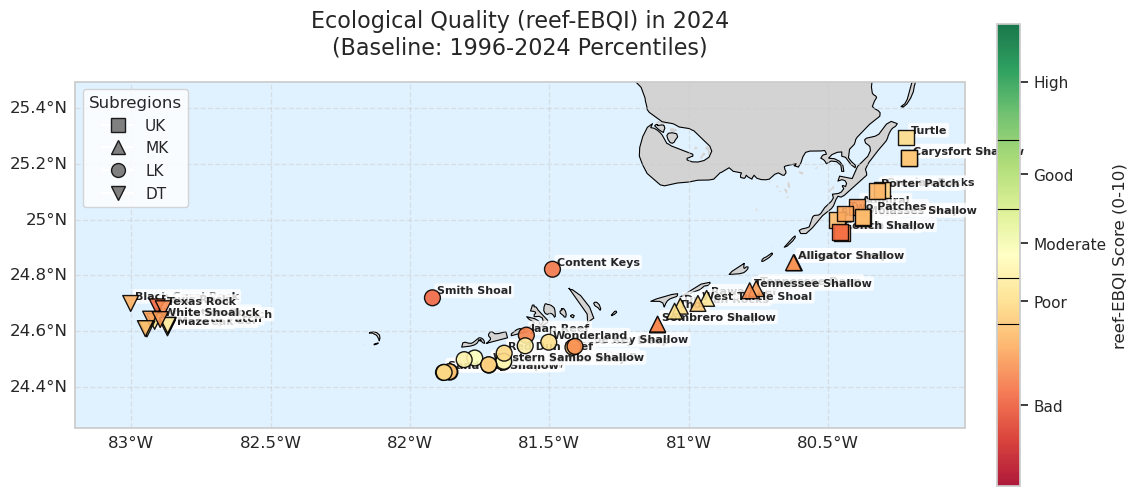

/tmp/ipykernel_1207842/4127411829.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ebqi_sel, x='Subregion', y='reef_EBQI', palette='Set2', ax=ax_box, showfliers=False)


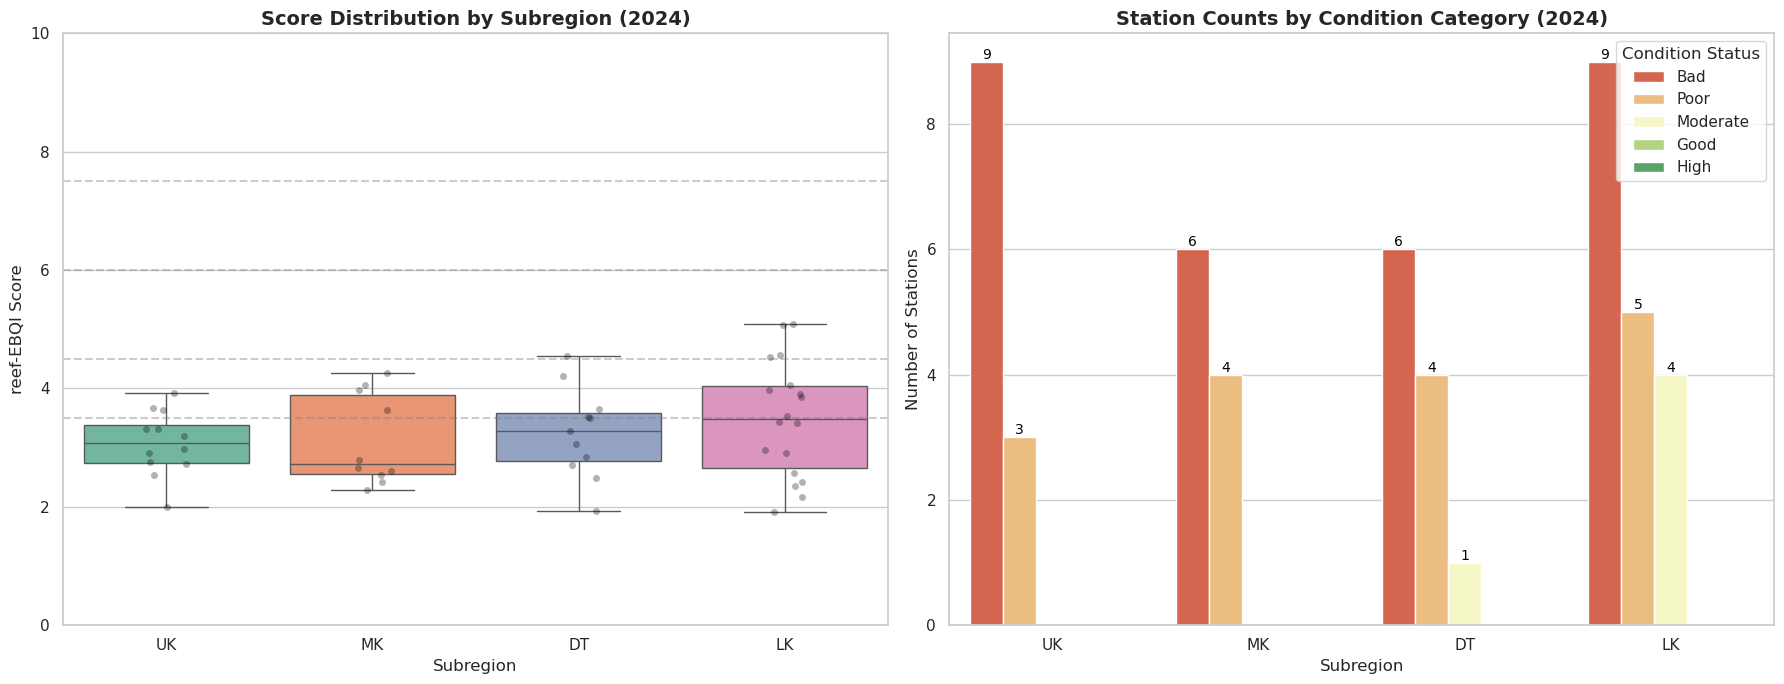


Summary Table: Number of Stations per Status (2024)


Status,Bad,Poor,Moderate
Subregion,,,
DT,6,4,1
LK,9,5,4
MK,6,4,0
UK,9,3,0


In [13]:
# 1. Prepare Geographic Coordinates - Include Subregion
df_coords = df_stations[['Site_name', 'latDD', 'lonDD', 'Subregion']].drop_duplicates(subset='Site_name')

# 2. Merge EBQI results with coordinates
df_ebqi_map = pd.merge(site_ebqi, df_coords, left_on='SiteName', right_on='Site_name')

# 3. Filter for the selected year and status
selected_year = 2024
df_ebqi_sel = df_ebqi_map[df_ebqi_map['SampleYear'] == selected_year].copy()

target_status = 'All'  # Options: 'All', 'Bad', 'Poor', 'Moderate', 'Good', 'High'

if target_status == 'All':
    df_plot = df_ebqi_sel.copy()
else:
    df_plot = df_ebqi_sel[df_ebqi_sel['Status'] == target_status].copy()

# Setup the figure
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add high-resolution geographic features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8, zorder=2)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff', zorder=0)

# --- SYMBOL MAPPING LOGIC ---
marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}
sc = None

# Iterate through subregions to apply unique markers
for sub, mkr in marker_map.items():
    # Filter for sites within this specific subregion
    sub_data = df_plot[df_plot['Subregion'] == sub]
    
    if not sub_data.empty:
        sc = ax.scatter(sub_data['lonDD'], sub_data['latDD'], 
                        c=sub_data['reef_EBQI'], cmap='RdYlGn', marker=mkr,
                        s=130, edgecolor='black', alpha=0.9, 
                        transform=ccrs.PlateCarree(), zorder=4, 
                        vmin=0, vmax=10)

# 4. Colorbar Configuration
if sc:
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.6)
    cbar.set_label('reef-EBQI Score (0-10)', fontsize=12)
    
    status_ticks = [1.75, 4.0, 5.25, 6.75, 8.75]
    status_labels = ['Bad', 'Poor', 'Moderate', 'Good', 'High']
    cbar.set_ticks(status_ticks)
    cbar.set_ticklabels(status_labels)
    
    for threshold in [3.5, 4.5, 6.0, 7.5]:
        cbar.ax.axhline(threshold, color='black', linewidth=0.8)

# 5. Legend for Subregions (Outside map)
legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                          markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                   for k, m in marker_map.items()]
ax.legend(handles=legend_elements, loc='upper left', title="Subregions", frameon=True)

# 6. Set map limits and labels
ax.set_extent([df_ebqi_map['lonDD'].min() - 0.2, df_ebqi_map['lonDD'].max() + 0.2,
               df_ebqi_map['latDD'].min() - 0.2, df_ebqi_map['latDD'].max() + 0.2], 
              crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, zorder=3)
gl.top_labels = False
gl.right_labels = False

# 7. Labels for problematic or filtered sites
for idx, row in df_plot.iterrows():
    # If we are looking at a specific status, label everything, otherwise just the 'Bad'/'Poor'
    if target_status != 'All' or row['Status'] in ['Bad', 'Poor']: 
        ax.text(row['lonDD'] + 0.015, row['latDD'] + 0.015, row['SiteName'],
                fontsize=8, transform=ccrs.PlateCarree(), fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8, ec='none'))

plt.title(f'Ecological Quality (reef-EBQI) in {selected_year}\n(Baseline: 1996-2024 Percentiles)', fontsize=16, pad=20)
plt.show()

# --- 8. Categorical Distribution Analysis ---

# Set the categorical order for the health status
status_order = ['Bad', 'Poor', 'Moderate', 'Good', 'High']
df_ebqi_sel['Status'] = pd.Categorical(df_ebqi_sel['Status'], categories=status_order, ordered=True)

# Create a figure with two subplots: a Box Plot (scores) and a Count Plot (number of stations)
fig, (ax_box, ax_count) = plt.subplots(1, 2, figsize=(18, 7))

# A. Box Plot: Distribution of reef-EBQI scores per Subregion
sns.boxplot(data=df_ebqi_sel, x='Subregion', y='reef_EBQI', palette='Set2', ax=ax_box, showfliers=False)
sns.stripplot(data=df_ebqi_sel, x='Subregion', y='reef_EBQI', color='black', alpha=0.3, jitter=True, ax=ax_box)

# Add horizontal threshold lines to the box plot to match EBQI categories
for threshold in [3.5, 4.5, 6.0, 7.5]:
    ax_box.axhline(threshold, color='gray', linestyle='--', alpha=0.4)

ax_box.set_title(f'Score Distribution by Subregion ({selected_year})', fontsize=14, fontweight='bold')
ax_box.set_ylabel('reef-EBQI Score')
ax_box.set_ylim(0, 10)

# B. Count Plot: Number of stations in each condition category per Subregion
# This directly addresses your request for "number of stations"
sns.countplot(data=df_ebqi_sel, x='Subregion', hue='Status', palette='RdYlGn', ax=ax_count)

ax_count.set_title(f'Station Counts by Condition Category ({selected_year})', fontsize=14, fontweight='bold')
ax_count.set_ylabel('Number of Stations')
ax_count.legend(title='Condition Status', loc='upper right')

# Add labels on top of the bars for clarity
for p in ax_count.patches:
    if p.get_height() > 0:
        ax_count.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()

# --- 9. Summary Table Printout ---
print(f"\nSummary Table: Number of Stations per Status ({selected_year})")
summary_table = pd.crosstab(df_ebqi_sel['Subregion'], df_ebqi_sel['Status'])
display(summary_table)

#### Spider-web plot by ecological status

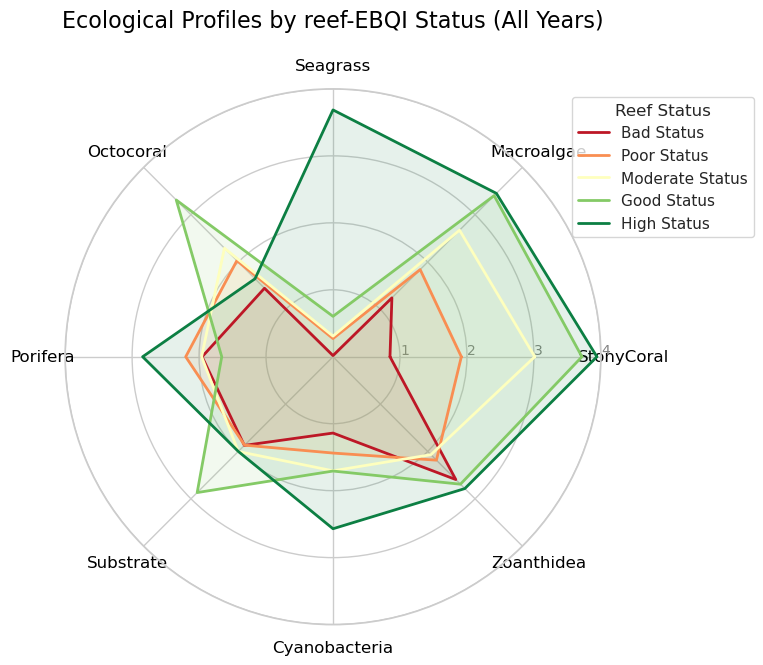

In [14]:
# Plot index for a selected year
# year_selection = 1996
# df_selected_year = df_taxagroups[df_taxagroups['SampleYear'] == year_selection].copy()

# Or use all years for average profiles
df_selected_year = df_taxagroups.copy()

# --- Define Status Order and matching Colors from 'RdYlGn' ---
status_levels = ['Bad', 'Poor', 'Moderate', 'Good', 'High']
# Mapping statuses to normalized 0-1 values to pick colors from the RdYlGn colormap
# (0.0=Red, 0.5=Yellow, 1.0=Green)
status_colors = {
    'Bad':      cm.RdYlGn(0.05),
    'Poor':     cm.RdYlGn(0.25),
    'Moderate': cm.RdYlGn(0.50),
    'Good':     cm.RdYlGn(0.75),
    'High':     cm.RdYlGn(0.95)
}

# Extract S-scores and include the reef_EBQI / Status
def get_scores_and_status(row):
    # Recalculate S-scores
    scores = {
        'StonyCoral':    score_positive(row['StonyCoral'], threshold_map['StonyCoral']),
        'Macroalgae':    score_negative(row['Macroalgae'], threshold_map['Macroalgae']),
        'Seagrass':      score_positive(row['Seagrass'],   threshold_map['Seagrass']),
        'Octocoral':     score_positive(row['Octocoral'],  threshold_map['Octocoral']),
        'Porifera':      score_negative(row['Porifera'],   threshold_map['Porifera']),
        'Substrate':     score_negative(row['Substrate'], threshold_map['Substrate']),
        'Cyanobacteria': score_negative(row['Cyanobacteria'], threshold_map['Cyanobacteria']),
        'Zoanthidea':    score_negative(row['Zoanthidea'],  threshold_map['Zoanthidea'])
    }
    # Calculate EBQI and Status to ensure we are grouping correctly
    ebqi = calculate_refined_ebqi(row)
    scores['Status'] = get_status(ebqi)
    return pd.Series(scores)

# --- Apply to get scores grouped by Status ---
df_scores_status = df_selected_year.apply(get_scores_and_status, axis=1)

# Prepare Plotting Basics
categories = ['StonyCoral', 'Macroalgae', 'Seagrass', 'Octocoral', 'Porifera', 'Substrate', 'Cyanobacteria', 'Zoanthidea']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# --- Loop through each Status level to plot separate profiles ---
for status in status_levels:
    # Filter for the status and calculate mean S-scores
    subset = df_scores_status[df_scores_status['Status'] == status]
    
    if not subset.empty:
        mean_vals = subset[categories].mean().values.tolist()
        mean_vals += mean_vals[:1] # Close the circle
        
        # Plot the line
        ax.plot(angles, mean_vals, linewidth=2, linestyle='solid', 
                color=status_colors[status], label=f'{status} Status')
        
        # Fill the area with low alpha
        ax.fill(angles, mean_vals, color=status_colors[status], alpha=0.1)

# 4. Final Formatting
plt.xticks(angles[:-1], categories, color='black', size=12)
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4], ["1", "2", "3", "4"], color="grey", size=10)
plt.ylim(0, 4)

plt.title(f'Ecological Profiles by reef-EBQI Status (All Years)',
          size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), title="Reef Status")

plt.tight_layout()
plt.show()

## Satellite data analysis: SST and Chl-a
#### The next cells extract SST and Chl-a data and compute trends for each CREMP monitoring site

#### Downloading MONTHLY SST data. If data has already been downloaded, skip this cell.

In [ ]:
# Setup the URL and local filename (Mirroring the MATLAB logic)
save_dest = "SST_Monthly_Data_Subset.nc"

# Define Parameters
n_lat = 25.4
s_lat = 24.4
e_lon = -79.5
w_lon = -83
start_time = '2002-06-16T00:00:00Z'
end_time = '2025-12-16T00:00:00Z'

# 2. Construct the URL using f-strings
# We use w_lon (min) to e_lon (max) for the longitude bracket
base_url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41mday.nc"
constraints = (
    f"sst[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})],"
    f"nobs[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})],"
    f"mask[({start_time}):1:({end_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
)

url = f"{base_url}?{constraints}"

print("Downloading data from ERDDAP... This may take a minute.")

try:
    # Download the file 
    with requests.get(url, stream=True, timeout=1200) as r:
        r.raise_for_status()
        with open(save_dest, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"File saved successfully as {save_dest}")

    # Open the local file with xarray
    ds_sst_monthly = xr.open_dataset(save_dest)
    print("SST data successfully loaded into xarray.")
    display(ds_sst_monthly)

except requests.exceptions.HTTPError as err:
    print(f"HTTP Error: {err}")
    print("Double check that your coordinate bounds (Lat/Lon) are within the dataset range.")
except Exception as e:
    print(f"An error occurred: {e}")

#### Downloading DAILY SST data. If data has already been downloaded, skip this cell.

In [ ]:
# Define Parameters
base_url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.nc"
n_lat, s_lat = 25.4, 24.4
e_lon, w_lon = -79.5, -83

# Define the range of years
years = range(2002, 2026)  # From 2002 to 2025
output_dir = "SST_Chunks"
os.makedirs(output_dir, exist_ok=True)

downloaded_files = []

for year in years:
    save_dest = os.path.join(output_dir, f"SST_Daily_{year}.nc")
    
    # Define start/end for the specific year
    # Adjusted to ensure we don't request data before the start of the dataset (June 2002)
    s_time = f"{year}-01-01T09:00:00Z" if year > 2002 else "2002-06-16T09:00:00Z"
    e_time = f"{year}-12-31T09:00:00Z"
    
    # Construct URL for this chunk
    constraints = (
        f"analysed_sst[({s_time}):1:({e_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})],"
        f"mask[({s_time}):1:({e_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
    )
    url = f"{base_url}?{constraints}"
    
    if os.path.exists(save_dest):
        print(f"File for {year} already exists. Skipping...")
        downloaded_files.append(save_dest)
        continue

    print(f"Downloading {year}...")
    try:
        with requests.get(url, stream=True, timeout=600) as r:
            r.raise_for_status()
            with open(save_dest, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        downloaded_files.append(save_dest)
    except Exception as e:
        print(f"Failed to download {year}: {e}")

# 2. Open all chunks as a single dataset
# open_mfdataset (Multi-File Dataset) is highly efficient
print("\nMerging files into xarray...")
ds_sst_daily = xr.open_mfdataset(downloaded_files, combine='by_coords')

# Rename variable to match your previous scripts
if 'analysed_sst' in ds_sst_daily:
    ds_sst_daily = ds_sst_daily.rename({'analysed_sst': 'sst'})

print("Complete. Total Time Steps:", len(ds_sst_daily.time))
display(ds_sst_daily)

# Save the merged dataset for future use
merged_save_path = "SST_Daily_Merged_2002_2025.nc"
ds_sst_daily.to_netcdf(merged_save_path)

#### If SST data has been downloaded, load monthly and daily tables

In [15]:
#Define paths to your merged datasets
path_daily = "~/multitressor/SST_Daily_Merged_2002_2025.nc"
path_monthly = "~/multitressor/SST_Monthly_Data_Subset.nc"

print("Checking for files...")
for p in [path_daily, path_monthly]:
    if os.path.exists(p):
        print(f"  [OK] Found: {os.path.basename(p)}")
    else:
        print(f"  [MISSING] Could not find: {p}")

# Load the datasets
try:
    # We use chunks={} to enable dask-backed lazy loading for the large daily file
    ds_sst_daily = xr.open_dataset(path_daily, chunks={'time': 500})
    print("\nDaily Merged SST loaded successfully.")
    
    ds_sst_monthly = xr.open_dataset(path_monthly)
    print("Monthly SST Subset loaded successfully.")
    
    # Display the daily dataset to check time range and variables
    display(ds_sst_daily)

except Exception as e:
    print(f"\nError loading datasets: {e}")

Checking for files...
  [MISSING] Could not find: ~/multitressor/SST_Daily_Merged_2002_2025.nc
  [MISSING] Could not find: ~/multitressor/SST_Monthly_Data_Subset.nc

Daily Merged SST loaded successfully.
Monthly SST Subset loaded successfully.


<xarray.Dataset> Size: 4GB
Dimensions:    (time: 8598, latitude: 101, longitude: 351)
Coordinates:
  * time       (time) datetime64[ns] 69kB 2002-06-16T09:00:00 ... 2025-12-31T...
  * latitude   (latitude) float32 404B 24.4 24.41 24.42 ... 25.38 25.39 25.4
  * longitude  (longitude) float32 1kB -83.0 -82.99 -82.98 ... -79.51 -79.5
Data variables:
    sst        (time, latitude, longitude) float64 2GB dask.array<chunksize=(500, 101, 351), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 1GB dask.array<chunksize=(500, 101, 351), meta=np.ndarray>
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2002-12-31T09:00:00Z
    time_coverage_start:        2002-06-16T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -83.0

#### Extract SST for CREMP Stations

Extracting 3x3 pixel data. Mode: Daily -> Resampled Monthly


/home/enrique.montes@CNS.local/miniconda3/envs/corals/lib/python3.11/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


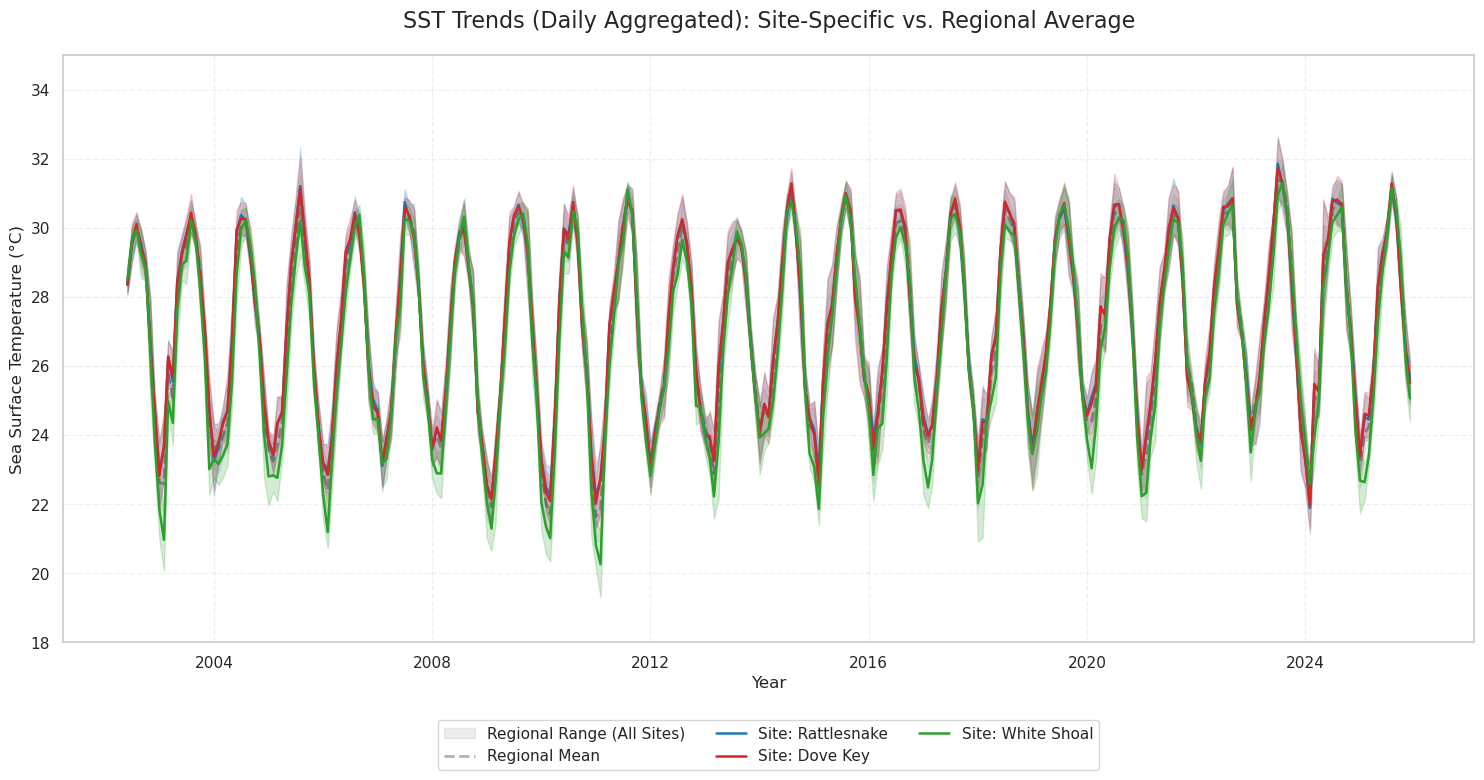

In [16]:
# Select either ds_sst_daily or ds_sst_monthly as needed
ds_input = ds_sst_daily 

# 1. Prepare unique site list
df_unique_sites = df_stations[['Site_name', 'latDD', 'lonDD']].drop_duplicates(subset='Site_name')

# 2. Iteratively extract 3x3 pixel box for each site
site_sst_results = {}

# Detect if the dataset is daily or monthly based on the time delta
time_diff = ds_input.time.diff('time').median().values / np.timedelta64(1, 'D')
is_daily = time_diff < 5  # True if data is daily (~1 day), False if monthly (~30 days)

print(f"Extracting 3x3 pixel data. Mode: {'Daily -> Resampled Monthly' if is_daily else 'Monthly'}")

for idx, row in df_unique_sites.iterrows():
    site = row['Site_name']
    lat, lon = row['latDD'], row['lonDD']
    
    # Find center indices
    center_ds = ds_input.sel(latitude=lat, longitude=lon, method='nearest')
    lat_idx = np.abs(ds_input.latitude - center_ds.latitude).argmin().item()
    lon_idx = np.abs(ds_input.longitude - center_ds.longitude).argmin().item()
    
    # Extract 3x3 grid
    subset = ds_input.sst.isel(
        latitude=slice(lat_idx - 1, lat_idx + 2),
        longitude=slice(lon_idx - 1, lon_idx + 2)
    )
    
    # Calculate spatial mean for the 3x3 box
    spatial_mean = subset.mean(dim=['latitude', 'longitude'])
    
    if is_daily:
        # AGGREGATION: Resample daily spatial means to monthly mean and SD
        # 'MS' = Month Start frequency
        site_mean = spatial_mean.resample(time='MS').mean()
        site_std = spatial_mean.resample(time='MS').std()
    else:
        # Standard spatial SD for monthly data
        site_mean = spatial_mean
        site_std = subset.std(dim=['latitude', 'longitude'])
    
    # Convert to dataframe
    df_site = pd.DataFrame({
        'Date': site_mean.time.values,
        'SST_Mean': site_mean.values,
        'SST_SD': site_std.values
    }).dropna() # Drop any months with missing data
    
    df_site['Site_name'] = site
    site_sst_results[site] = df_site

# Combine all sites
df_sst_master = pd.concat(site_sst_results.values(), ignore_index=True)

# 3. Plotting with Regional Reference
selected_sites = ['Rattlesnake', 'Dove Key', 'White Shoal']
colors = {'Rattlesnake': '#1f77b4', 'Dove Key': '#d62728', 'White Shoal': '#2ca02c'}

# Group by Date to get the regional average
regional_ref = df_sst_master.groupby('Date').agg({
    'SST_Mean': 'mean',
    'SST_SD': 'mean'
}).reset_index()

plt.figure(figsize=(15, 8))

# Background Regional Reference
plt.fill_between(regional_ref['Date'], 
                 regional_ref['SST_Mean'] - regional_ref['SST_SD'], 
                 regional_ref['SST_Mean'] + regional_ref['SST_SD'], 
                 color='black', alpha=0.07, label='Regional Range (All Sites)')
plt.plot(regional_ref['Date'], regional_ref['SST_Mean'], 
         color='black', linestyle='--', linewidth=2, alpha=0.3, label='Regional Mean')

# Plot Selected Sites
for site in selected_sites:
    plot_data = site_sst_results.get(site)
    if plot_data is not None:
        plt.fill_between(plot_data['Date'], 
                         plot_data['SST_Mean'] - plot_data['SST_SD'], 
                         plot_data['SST_Mean'] + plot_data['SST_SD'], 
                         color=colors[site], alpha=0.2)
        plt.plot(plot_data['Date'], plot_data['SST_Mean'], 
                 color=colors[site], linewidth=1.8, label=f'Site: {site}')

# Formatting and Titles
data_mode = "Daily Aggregated" if is_daily else "Monthly"
plt.title(f'SST Trends ({data_mode}): Site-Specific vs. Regional Average', fontsize=16, pad=20)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylim(18, 35) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Comparing satellite SST vs. in situ temperature

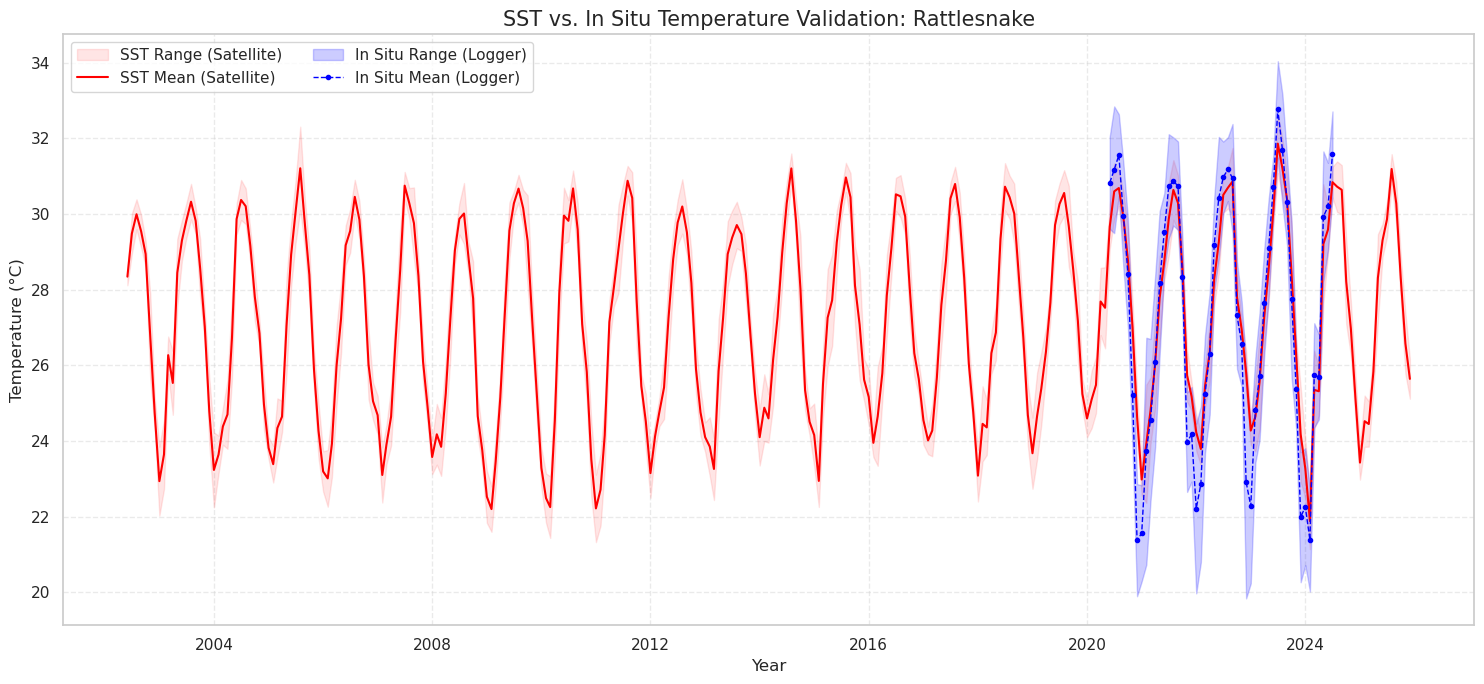

In [17]:
# Load and Merge In Situ Temperature Data
# Using the paths provided for monitoring sites
cremp_temp_path = "~/multitressor/CREMP_CSV_Files/CREMP_Temperature_2024.csv"
dtcremp_temp_path = "~/multitressor/DTCREMP_CSV_Files/DTCREMP_Temperature_2024.csv"

df_cremp_temp = pd.read_csv(cremp_temp_path)
df_dtcremp_temp = pd.read_csv(dtcremp_temp_path)

# Combine both monitoring programs into one dataframe
df_insitu = pd.concat([df_cremp_temp, df_dtcremp_temp], ignore_index=True)

# Create Date and calculate Monthly Mean/SD
# Constructing datetime from individual Year, Month, Day columns
df_insitu['SampleDate'] = pd.to_datetime(df_insitu[['Year', 'Month', 'Day']])
df_insitu['YearMonth'] = df_insitu['SampleDate'].dt.to_period('M')

# Calculate the mean and standard deviation for TempC per site/month
insitu_monthly = df_insitu.groupby(['SiteName', 'YearMonth'])['TempC'].agg(['mean', 'std']).reset_index()
insitu_monthly.rename(columns={'mean': 'InSitu_Mean', 'std': 'InSitu_SD'}, inplace=True)

# Alignment with Satellite Data (ensuring site_sst_results has YearMonth)
for site in site_sst_results:
    if 'YearMonth' not in site_sst_results[site].columns:
        site_sst_results[site]['YearMonth'] = pd.to_datetime(site_sst_results[site]['Date']).dt.to_period('M')

# Plot Comparison for a selected site
selected_site = "Rattlesnake"
sst_plot_data = site_sst_results.get(selected_site)
insitu_plot_data = insitu_monthly[insitu_monthly['SiteName'] == selected_site].copy()

# Convert YearMonth back to timestamp for the X-axis
insitu_plot_data['Date'] = insitu_plot_data['YearMonth'].dt.to_timestamp()

if sst_plot_data is not None and not insitu_plot_data.empty:
    plt.figure(figsize=(15, 7))
    
    # --- Plot Satellite SST ---
    plt.fill_between(sst_plot_data['Date'], 
                     sst_plot_data['SST_Mean'] - sst_plot_data['SST_SD'], 
                     sst_plot_data['SST_Mean'] + sst_plot_data['SST_SD'], 
                     color='red', alpha=0.1, label='SST Range (Satellite)')
    plt.plot(sst_plot_data['Date'], sst_plot_data['SST_Mean'], 
             color='red', linewidth=1.5, label='SST Mean (Satellite)')
    
    # --- Plot In Situ Temperature ---
    plt.fill_between(insitu_plot_data['Date'], 
                     insitu_plot_data['InSitu_Mean'] - insitu_plot_data['InSitu_SD'], 
                     insitu_plot_data['InSitu_Mean'] + insitu_plot_data['InSitu_SD'], 
                     color='blue', alpha=0.2, label='In Situ Range (Logger)')
    plt.plot(insitu_plot_data['Date'], insitu_plot_data['InSitu_Mean'], 
             color='blue', marker='o', markersize=3, linestyle='--', 
             linewidth=1, label='In Situ Mean (Logger)')

    # Formatting
    plt.title(f'SST vs. In Situ Temperature Validation: {selected_site}', fontsize=15)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend(loc='upper left', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print(f"Data missing for '{selected_site}'. Check spelling or if data exists for this site.")

#### SST distribution by site (ordered by median)

/tmp/ipykernel_1207842/244718932.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1207842/244718932.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10)


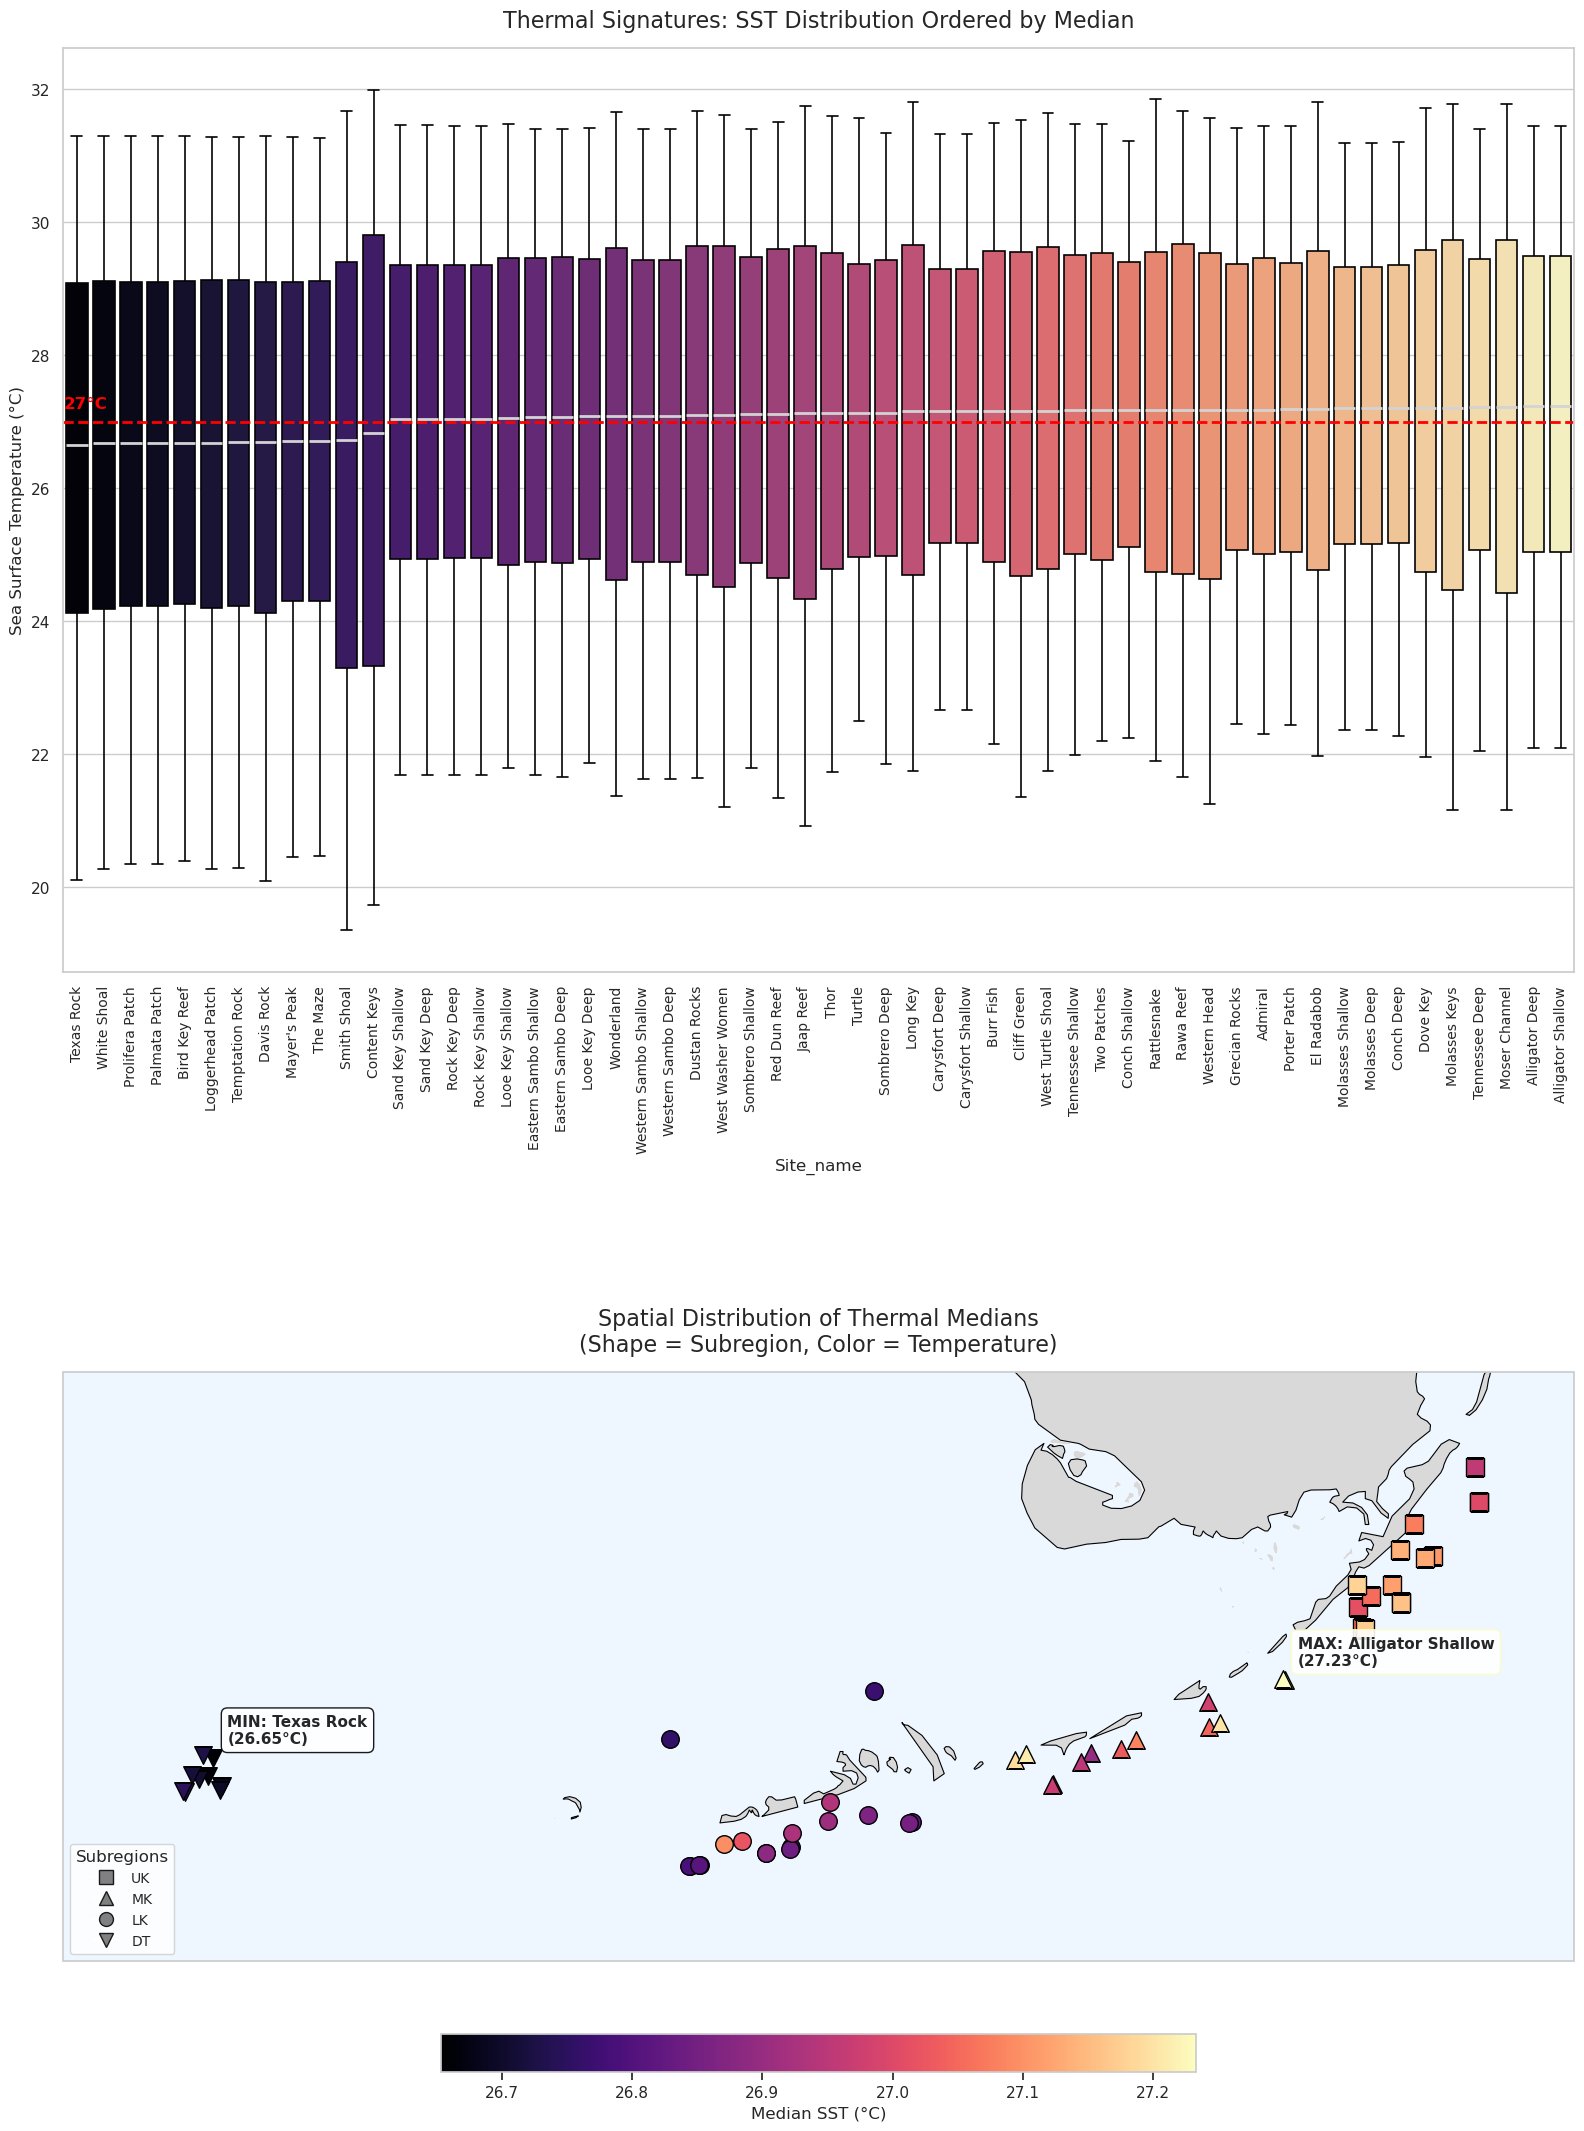

/tmp/ipykernel_1207842/244718932.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_sub = sns.boxplot(


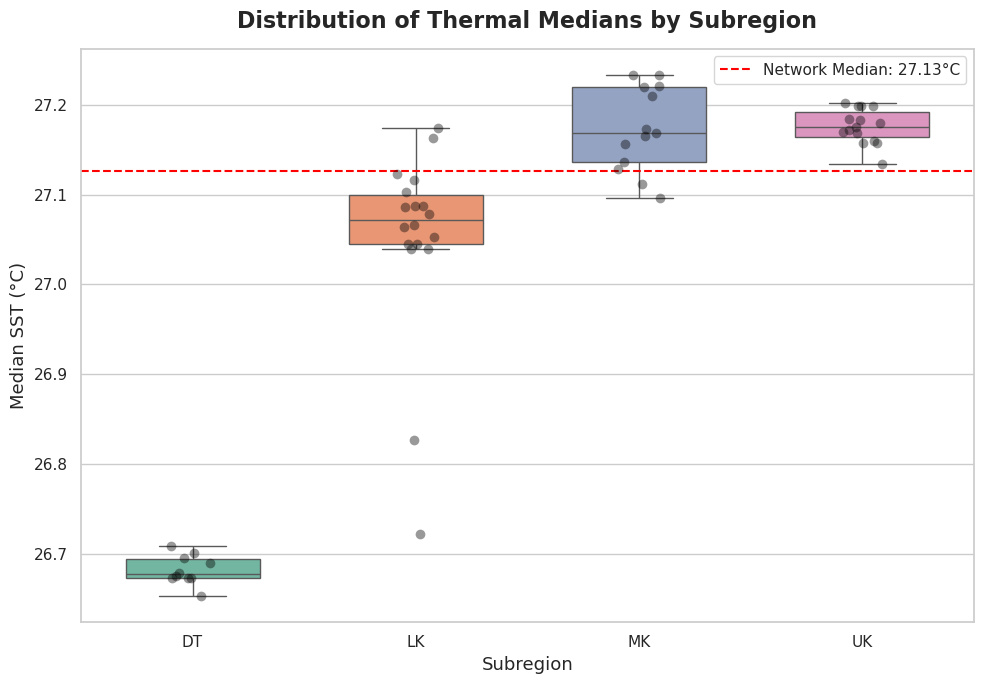


Descriptive Statistics for Thermal Medians per Subregion:


,count,mean,std,min,25%,50%,75%,max
Subregion,,,,,,,,
DT,10.0,26.683,0.016,26.653,26.674,26.678,26.695,26.709
LK,18.0,27.051,0.109,26.723,27.045,27.072,27.099,27.174
MK,13.0,27.173,0.047,27.096,27.136,27.168,27.220,27.233
UK,15.0,27.176,0.019,27.134,27.164,27.175,27.191,27.201


In [18]:
# 1. Prepare Data and Color Mapping
# Calculate the median SST and sort for the color mapping
site_medians = df_sst_master.groupby('Site_name')['SST_Mean'].median().sort_values()
site_order = site_medians.index

# Identify Highest and Lowest sites
lowest_site_name = site_order[0]
highest_site_name = site_order[-1]

# Generate the Color Map (matching 'magma')
norm = mcolors.Normalize(vmin=0, vmax=len(site_order)-1)
cmap = plt.get_cmap('magma')
site_colors = {site: cmap(norm(i)) for i, site in enumerate(site_order)}

# Symbol Logic Mapping
marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}

# --- FIGURE SETUP ---
fig = plt.figure(figsize=(16, 22))

# --- TOP: THE BOX PLOT ---
ax1 = fig.add_subplot(2, 1, 1)
sns.boxplot(
    data=df_sst_master, 
    x='Site_name', 
    y='SST_Mean', 
    order=site_order, 
    palette='magma',
    ax=ax1,
    fliersize=1,
    linewidth=1.2,
    medianprops={'color': 'lightgrey', 'linewidth': 2}
)

ax1.axhline(27, color='red', linestyle='--', linewidth=2, label='Threshold: 27°C')
ax1.text(-0.5, 27.2, '27°C', color='red', fontweight='bold', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10)
ax1.set_title('Thermal Signatures: SST Distribution Ordered by Median', fontsize=16, pad=15)
ax1.set_ylabel('Sea Surface Temperature (°C)', fontsize=12)

# --- BOTTOM: THE MAP ---
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
                df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)

# Plot sites using both Color (Temperature) and Shape (Subregion)
for site in site_order:
    coords = df_coords[df_coords['Site_name'] == site]
    if not coords.empty:
        lon, lat = coords['lonDD'].iloc[0], coords['latDD'].iloc[0]
        subregion = coords['Subregion'].iloc[0]
        
        # Determine dot color and marker shape
        current_color = site_colors[site]
        current_marker = marker_map.get(subregion, 'o') # Default to circle if not found
        
        ax2.scatter(lon, lat, color=current_color, marker=current_marker,
                    s=160, edgecolor='black', zorder=3, transform=ccrs.PlateCarree())
        
        # Annotate MIN/MAX sites
        if site == lowest_site_name or site == highest_site_name:
            prefix = "MIN" if site == lowest_site_name else "MAX"
            label_text = f"{prefix}: {site}\n({site_medians[site]:.2f}°C)"
            ax2.text(lon + 0.03, lat + 0.03, label_text,
                     transform=ccrs.PlateCarree(), fontsize=11, fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.9, edgecolor=current_color, boxstyle='round,pad=0.4'),
                     zorder=5)

# --- ADD LEGENDS ---
# 1. Temperature Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=site_medians.min(), vmax=site_medians.max()))
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
cbar.set_label('Median SST (°C)', fontsize=12)

# 2. Subregion Symbol Legend
symbol_legend = [Line2D([0], [0], marker=m, color='w', label=k,
                        markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='lower left', title="Subregions", frameon=True, fontsize=10)

ax2.set_title('Spatial Distribution of Thermal Medians\n(Shape = Subregion, Color = Temperature)', fontsize=16, pad=15)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

# --- SUBREGION THERMAL DISTRIBUTION ---

# 1. Prepare a dataframe of site medians with their subregions
df_site_medians = site_medians.reset_index()
df_site_medians.columns = ['Site_name', 'Median_SST']

# Merge with coordinates to get the Subregion column
df_subregion_medians = pd.merge(df_site_medians, df_coords[['Site_name', 'Subregion']], on='Site_name')

# 2. Render the Box Plot
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot
ax_sub = sns.boxplot(
    data=df_subregion_medians, 
    x='Subregion', 
    y='Median_SST', 
    palette='Set2', 
    showfliers=False,
    width=0.6
)

# Overlay individual site medians as points to show distribution density
sns.stripplot(
    data=df_subregion_medians, 
    x='Subregion', 
    y='Median_SST', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=7
)

# 3. Formatting
plt.title('Distribution of Thermal Medians by Subregion', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Median SST (°C)', fontsize=13)
plt.xlabel('Subregion', fontsize=13)

# Add a reference line for the overall network median
network_median = df_subregion_medians['Median_SST'].median()
plt.axhline(network_median, color='red', linestyle='--', linewidth=1.5, label=f'Network Median: {network_median:.2f}°C')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print Descriptive Statistics
print("\nDescriptive Statistics for Thermal Medians per Subregion:")
display(df_subregion_medians.groupby('Subregion')['Median_SST'].describe().round(3))

#### Mann-Kendall on deseasonalized monthly anomalies

In [19]:
# 1. Initialize list to store results
mk_anomaly_results = []

print("Calculating Deseasonalized Monthly Anomalies and MK Trends...")

# 2. Iterate through each site
for site_name, df_site in tqdm(site_sst_results.items()):
    
    # Create a copy and ensure Date is datetime
    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # A. Resample to Monthly Mean
    # Ensure we produce a Series for the mapping to work smoothly
    df_monthly = df['SST_Mean'].resample('MS').mean().to_frame()
    
    # B. Calculate Climatology (Average for each month 1-12)
    df_monthly['Month'] = df_monthly.index.month
    climatology = df_monthly.groupby('Month')['SST_Mean'].mean()
    
    # C. Subtract Climatology to get Anomaly (Vectorized Fix)
    # .map() is faster and avoids the ValueError from .apply()
    df_monthly['Anomaly'] = df_monthly['SST_Mean'] - df_monthly['Month'].map(climatology)
    
    # D. Perform Mann-Kendall on the Anomaly
    data = df_monthly['Anomaly'].dropna().values
    
    if len(data) > 24: # Require at least 2 years of data
        res = mk.original_test(data)
        
        # E. Convert Slope to Decadal
        # Slope is °C/month -> *12 (Annual) *10 (Decadal)
        slope_per_decade = res.slope * 12 * 10
        
        mk_anomaly_results.append({
            'SiteName': site_name,
            'Trend': res.trend,
            'P_Value': res.p,
            'Z_Value': res.z,
            'Slope_Decade': slope_per_decade,
            'Significant': 'Significant' if res.p <= 0.05 else 'Not Significant'
        })

# 3. Create Summary DataFrame
df_mk_trends = pd.DataFrame(mk_anomaly_results)

print("\nAnomalous Trend Summary (Decadal):")
display(df_mk_trends.sort_values('Slope_Decade', ascending=False).head(10))

sig_sites = df_mk_trends[df_mk_trends['Significant'] == 'Significant']
print(f"Found {len(sig_sites)} sites with significant warming trends.")

Calculating Deseasonalized Monthly Anomalies and MK Trends...


100%|██████████| 57/57 [00:00<00:00, 79.01it/s]


Anomalous Trend Summary (Decadal):


,SiteName,Trend,P_Value,Z_Value,Slope_Decade,Significant
55,Bird Key Reef,increasing,3.754774e-13,7.264122,0.430309,Significant
33,Rock Key Shallow,increasing,6.661338e-16,8.076135,0.430099,Significant
44,Rock Key Deep,increasing,6.661338e-16,8.076135,0.430099,Significant
34,Sand Key Shallow,increasing,6.661338e-16,8.066079,0.429640,Significant
45,Sand Key Deep,increasing,6.661338e-16,8.066079,0.429640,Significant
51,Prolifera Patch,increasing,5.748735e-13,7.206300,0.428775,Significant
50,Palmata Patch,increasing,5.748735e-13,7.206300,0.428775,Significant
32,Western Sambo Shallow,increasing,1.554312e-15,7.975576,0.428170,Significant
43,Western Sambo Deep,increasing,1.554312e-15,7.975576,0.428170,Significant
53,Mayer's Peak,increasing,2.760014e-13,7.305602,0.426112,Significant


Found 56 sites with significant warming trends.


#### SST trend distribution and spatial hotspots

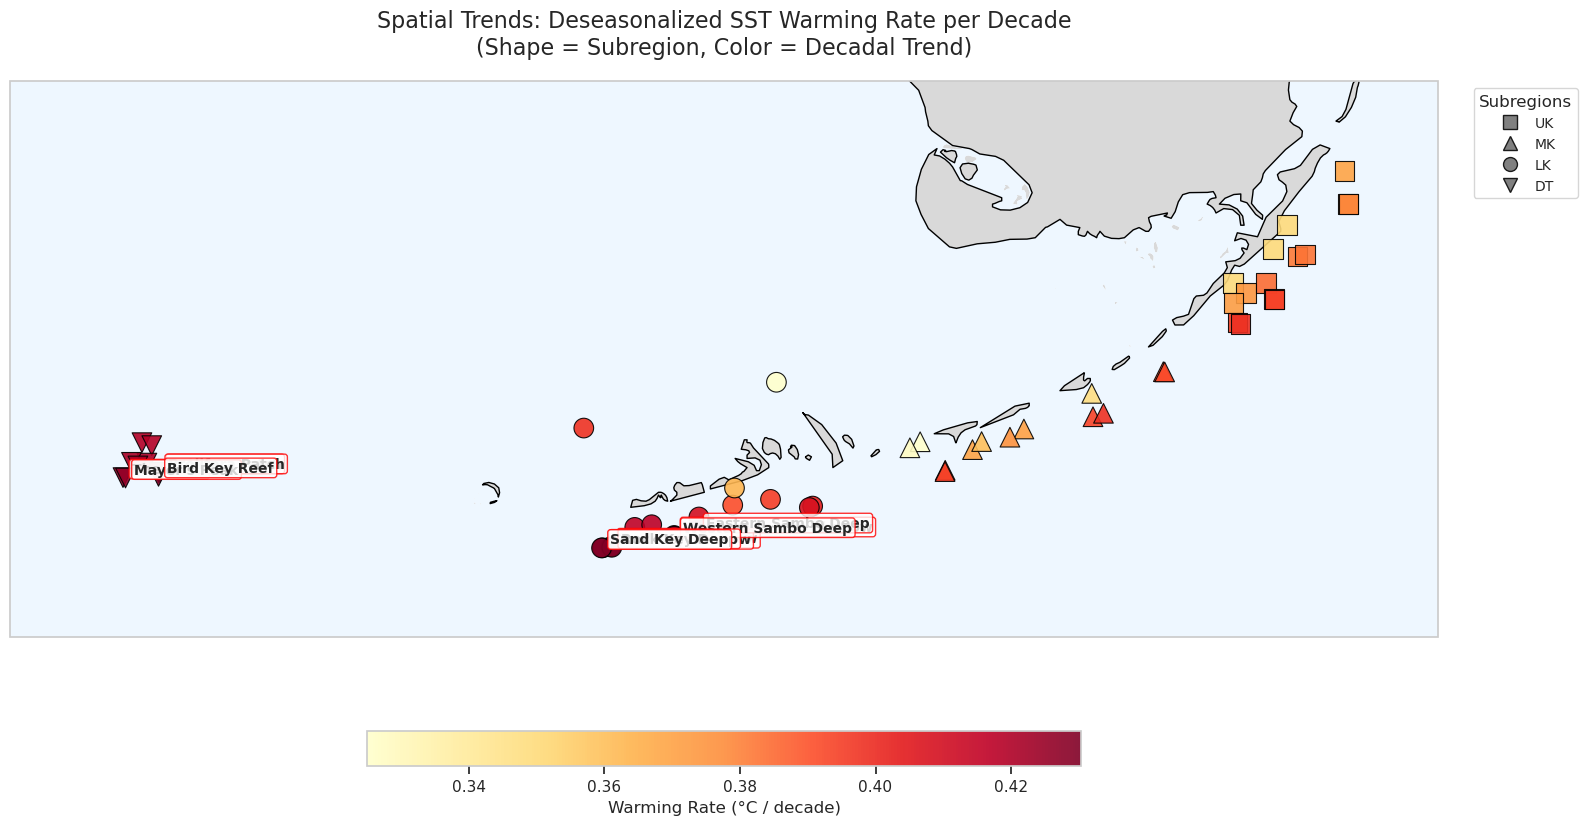

/tmp/ipykernel_1207842/2055245820.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_box = sns.boxplot(


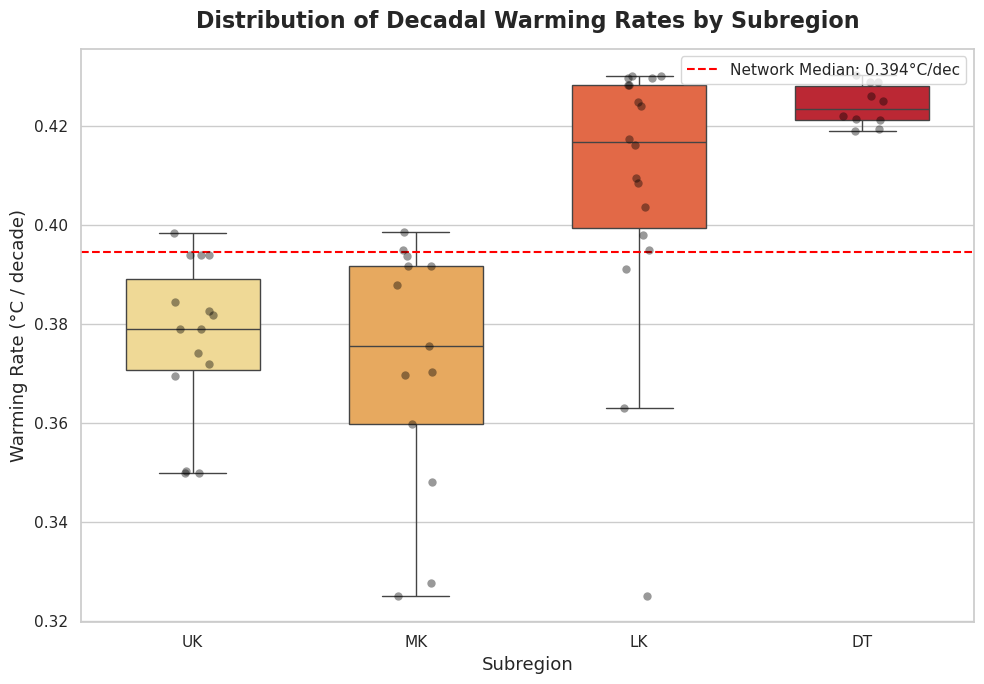


Descriptive Statistics for Decadal Warming Trends:


,count,mean,std,min,25%,50%,75%,max
Subregion,,,,,,,,
DT,10.0,0.4242,0.0041,0.4190,0.4213,0.4235,0.4281,0.4303
LK,18.0,0.4084,0.0276,0.3250,0.3994,0.4168,0.4282,0.4301
MK,13.0,0.3719,0.0253,0.3251,0.3597,0.3756,0.3916,0.3986
UK,15.0,0.3768,0.0163,0.3498,0.3707,0.3790,0.3891,0.3983


In [20]:
# --- 1. DATA PREPARATION ---
# Filter for significant trends and merge with coordinates
df_sig_trends = df_mk_trends[df_mk_trends['Significant'] == 'Significant'].copy()

# Ensure df_coords has 'Subregion' before merging
df_sig_coords = pd.merge(df_sig_trends, df_coords, left_on='SiteName', right_on='Site_name')

# Identify the 80th percentile threshold for the "Top Warming" sites
slope_threshold = df_sig_trends['Slope_Decade'].quantile(0.8)
df_high_warming = df_sig_coords[df_sig_coords['Slope_Decade'] >= slope_threshold]

# Symbol Logic Mapping
marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}

# --- 2. PLOTTING ---
fig = plt.figure(figsize=(16, 12)) 

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
                df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])

ax2.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#d9d9d9')
ax2.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#eef7ff')
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Define normalization for consistent color mapping across markers
vmin = df_sig_coords['Slope_Decade'].min()
vmax = df_sig_coords['Slope_Decade'].max()
norm_slope = mcolors.Normalize(vmin=vmin, vmax=vmax)

# --- ITERATIVE PLOTTING BY SUBREGION ---
sc = None
for sub, mkr in marker_map.items():
    sub_data = df_sig_coords[df_sig_coords['Subregion'] == sub]
    if not sub_data.empty:
        sc = ax2.scatter(sub_data['lonDD'], sub_data['latDD'], 
                         c=sub_data['Slope_Decade'], cmap='YlOrRd', marker=mkr,
                         s=200, edgecolor='black', linewidth=0.8, alpha=0.9,
                         zorder=3, transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)

# Add labels for the 80th percentile "Hotspots"
for i, row in df_high_warming.iterrows():
    ax2.text(row['lonDD'] + 0.02, row['latDD'] + 0.01, row['SiteName'],
             transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.2'),
             zorder=5)

# --- LEGENDS AND FORMATTING ---
# 1. Colorbar for warming rate
if sc:
    cbar = plt.colorbar(sc, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.08)
    cbar.set_label('Warming Rate (°C / decade)', fontsize=12)

# 2. Subregion Legend (Outside to the right)
symbol_legend = [mlines.Line2D([0], [0], marker=m, color='w', label=k,
                               markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                 for k, m in marker_map.items()]
ax2.legend(handles=symbol_legend, loc='upper left', bbox_to_anchor=(1.02, 1), 
          title="Subregions", frameon=True, fontsize=10)

ax2.set_title('Spatial Trends: Deseasonalized SST Warming Rate per Decade\n(Shape = Subregion, Color = Decadal Trend)', 
             fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# --- 3. DISTRIBUTION ANALYSIS BY SUBREGION ---

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Create the boxplot for warming rates per decade
# We use df_sig_coords to look at all significant trends calculated
ax_box = sns.boxplot(
    data=df_sig_coords, 
    x='Subregion', 
    y='Slope_Decade', 
    palette='YlOrRd', 
    showfliers=False,  # Hides outliers to focus on the interquartile range
    width=0.6
)

# Overlay individual site points (stripplot) for transparency on sample sizes
sns.stripplot(
    data=df_sig_coords, 
    x='Subregion', 
    y='Slope_Decade', 
    color='black', 
    alpha=0.4, 
    jitter=True,
    size=6
)

# Add a horizontal line representing the network-wide median warming rate
network_median_slope = df_sig_coords['Slope_Decade'].median()
plt.axhline(network_median_slope, color='red', linestyle='--', linewidth=1.5, 
            label=f'Network Median: {network_median_slope:.3f}°C/dec')

# Formatting labels and titles
plt.title('Distribution of Decadal Warming Rates by Subregion', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Warming Rate (°C / decade)', fontsize=13)
plt.xlabel('Subregion', fontsize=13)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print a quick statistical summary for reference
print("\nDescriptive Statistics for Decadal Warming Trends:")
display(df_sig_coords.groupby('Subregion')['Slope_Decade'].describe().round(4))

#### Compare warming rates versus baseline SST median. Are cooler sites warming faster?

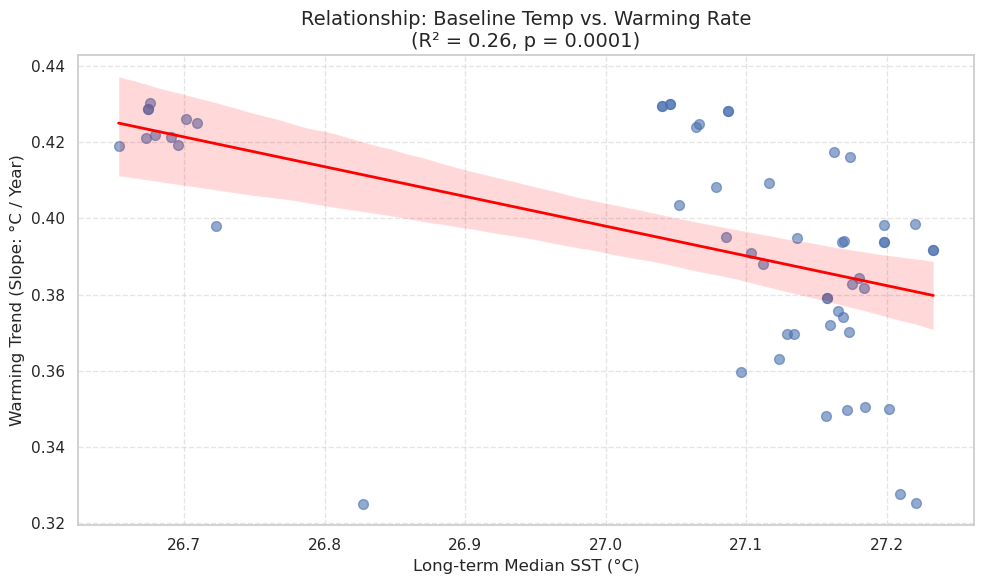

In [21]:
# 1. Prepare the data: Calculate the median for each site from your master SST table
df_medians = df_sst_master.groupby('Site_name')['SST_Mean'].median().reset_index()
df_medians.rename(columns={'SST_Mean': 'Median_SST'}, inplace=True)

# 2. Merge with your trend data (df_trends)
# Ensure df_trends contains the 'Slope' calculated in previous steps
df_analysis = pd.merge(df_sig_trends, df_medians, left_on='SiteName', right_on='Site_name')

# 3. Create the Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_analysis, x='Median_SST', y='Slope_Decade', 
            scatter_kws={'s': 50, 'alpha': 0.6}, 
            line_kws={'color': 'red', 'lw': 2})

# 4. Calculate Statistics for the title
slope, intercept, r_val, p_val, std_err = stats.linregress(df_analysis['Median_SST'], df_analysis['Slope_Decade'])

plt.title(f'Relationship: Baseline Temp vs. Warming Rate\n(R² = {r_val**2:.2f}, p = {p_val:.4f})', fontsize=14)
plt.xlabel('Long-term Median SST (°C)')
plt.ylabel('Warming Trend (Slope: °C / Year)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Thermal Regime Analysis (Boxplot)

/tmp/ipykernel_1207842/254711664.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_thermal, x='Thermal_Regime', y='Slope_Decade',


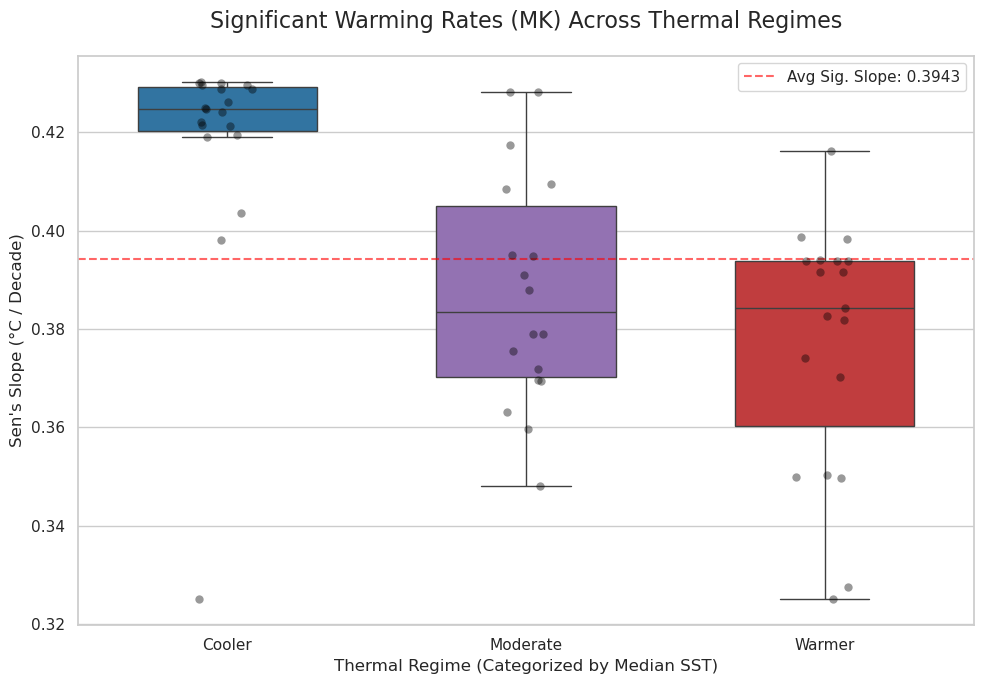

Summary Statistics for Significant Warming Slopes:


/tmp/ipykernel_1207842/254711664.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_thermal.groupby('Thermal_Regime')['Slope_Decade'].describe().round(4))


,count,mean,std,min,25%,50%,75%,max
Thermal_Regime,,,,,,,,
Cooler,19.0,0.4177,0.0241,0.3250,0.4203,0.4248,0.4292,0.4303
Moderate,18.0,0.3876,0.0234,0.3480,0.3702,0.3835,0.4050,0.4282
Warmer,19.0,0.3773,0.0253,0.3251,0.3603,0.3843,0.3939,0.4162


In [22]:
# 1. Calculate the long-term Median SST for each site to define the baseline
# We use the master SST table which contains all monthly/daily records
df_site_medians = df_sst_master.groupby('Site_name')['SST_Mean'].median().reset_index()
df_site_medians.rename(columns={'SST_Mean': 'Median_SST'}, inplace=True)

# 2. Merge your existing significant MK trends with these medians
# Note: df_sig_trends should contain 'Site_name' and 'Slope_Decade' (Sen's Slope)
df_thermal = pd.merge(df_sig_trends, df_site_medians, left_on='SiteName', right_on='Site_name')

# 3. Categorize into Thermal Regimes
# We use tertiles (3 groups) to define Cooler, Moderate, and Warmer sites
# Using 'qcut' ensures an equal number of sites in each category if possible
df_thermal['Thermal_Regime'] = pd.qcut(df_thermal['Median_SST'], 3, 
                                       labels=['Cooler', 'Moderate', 'Warmer'])

# 4. Create the Boxplot
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Define a palette that intuitively represents temperature
palette = {'Cooler': '#1f77b4', 'Moderate': '#9467bd', 'Warmer': '#d62728'}

# Plot the distribution of slopes per regime
ax = sns.boxplot(data=df_thermal, x='Thermal_Regime', y='Slope_Decade', 
                 palette=palette, showfliers=False, width=0.6)

# Overlay individual sites as points to see the distribution
sns.stripplot(data=df_thermal, x='Thermal_Regime', y='Slope_Decade', 
              color='black', alpha=0.4, size=6, jitter=True)

# 5. Formatting and Statistics
plt.title('Significant Warming Rates (MK) Across Thermal Regimes', fontsize=16, pad=20)
plt.ylabel('Sen\'s Slope (°C / Decade)', fontsize=12)
plt.xlabel('Thermal Regime (Categorized by Median SST)', fontsize=12)

# Add a dashed line for the overall mean slope of significant sites
avg_sig_slope = df_thermal['Slope_Decade'].mean()
plt.axhline(avg_sig_slope, color='red', linestyle='--', alpha=0.6, label=f'Avg Sig. Slope: {avg_sig_slope:.4f}')

plt.legend()
plt.tight_layout()
plt.show()

# Display the numerical summary
print("Summary Statistics for Significant Warming Slopes:")
display(df_thermal.groupby('Thermal_Regime')['Slope_Decade'].describe().round(4))

#### Fractionated download of daily 5km DHW data from: https://coastwatch.noaa.gov/erddap/griddap/noaacrwdhwDaily.html.

#### Skip this cell if .nc file with DWH data has already been generated (DHW_daily_merged_1986_2025)

In [ ]:
# 1. Define Parameters using the verified variable name
base_url = "https://coastwatch.noaa.gov/erddap/griddap/noaacrwdhwDaily.nc"
var_name = "degree_heating_week" # Verified from your working example

n_lat, s_lat = 25.4, 24.4
e_lon, w_lon = -79.5, -83

years = range(1986, 2026) 
output_dir = "DHW_Chunks"
os.makedirs(output_dir, exist_ok=True)

downloaded_dhw_files = []

print(f"Starting DHW Download using variable: {var_name}")

for year in years:
    save_dest = os.path.join(output_dir, f"DHW_Daily_{year}.nc")
    
    # Define time bounds for the year
    # Time must be in ISO 8601 format: YYYY-MM-DDTHH:MM:SSZ
    s_time = f"{year}-01-01T12:00:00Z"
    e_time = f"{year}-12-31T12:00:00Z"
    
    # Corrected Constraint String:
    # Format: variable[(time)][(lat)][(lon)]
    # Note: Longitude usually goes from Min (w_lon) to Max (e_lon)
    constraints = (
        f"{var_name}[({s_time}):1:({e_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})],"
        f"mask[({s_time}):1:({e_time})][({s_lat}):1:({n_lat})][({w_lon}):1:({e_lon})]"
    )
    url = f"{base_url}?{constraints}"
    
    if os.path.exists(save_dest):
        downloaded_dhw_files.append(save_dest)
        continue

    try:
        # We use a timeout to handle server delays
        with requests.get(url, stream=True, timeout=600) as r:
            if r.status_code == 500:
                print(f"Skipping {year}: 500 Server Error (likely no data for these coordinates/time yet).")
                continue
            r.raise_for_status()
            
            with open(save_dest, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        print(f"Successfully downloaded {year}.")
        downloaded_dhw_files.append(save_dest)
        
    except Exception as e:
        print(f"Failed {year}: {e}")

# 2. Open all successfully downloaded chunks
if downloaded_dhw_files:
    print("\nMerging DHW files into xarray...")
    # open_mfdataset handles the multi-year combine automatically
    ds_dhw = xr.open_mfdataset(downloaded_dhw_files, combine='by_coords')
    
    # Standardize name for consistency with your later code
    if var_name in ds_dhw:
        ds_dhw = ds_dhw.rename({var_name: 'dhw'})
    
    print("DHW Dataset successfully loaded.")
    display(ds_dhw)
else:
    print("No files were downloaded. Please check if the time range exists for this region.")

#### Extract DHW from single pixels centered at the site location

Extracting single-pixel DHW data for 57 sites...
Extraction complete.


,Year,DHW_Value,Site_name
0,1986,0.00,Rattlesnake
1,1987,0.33,Rattlesnake
2,1988,0.00,Rattlesnake
3,1989,0.00,Rattlesnake
4,1990,0.00,Rattlesnake


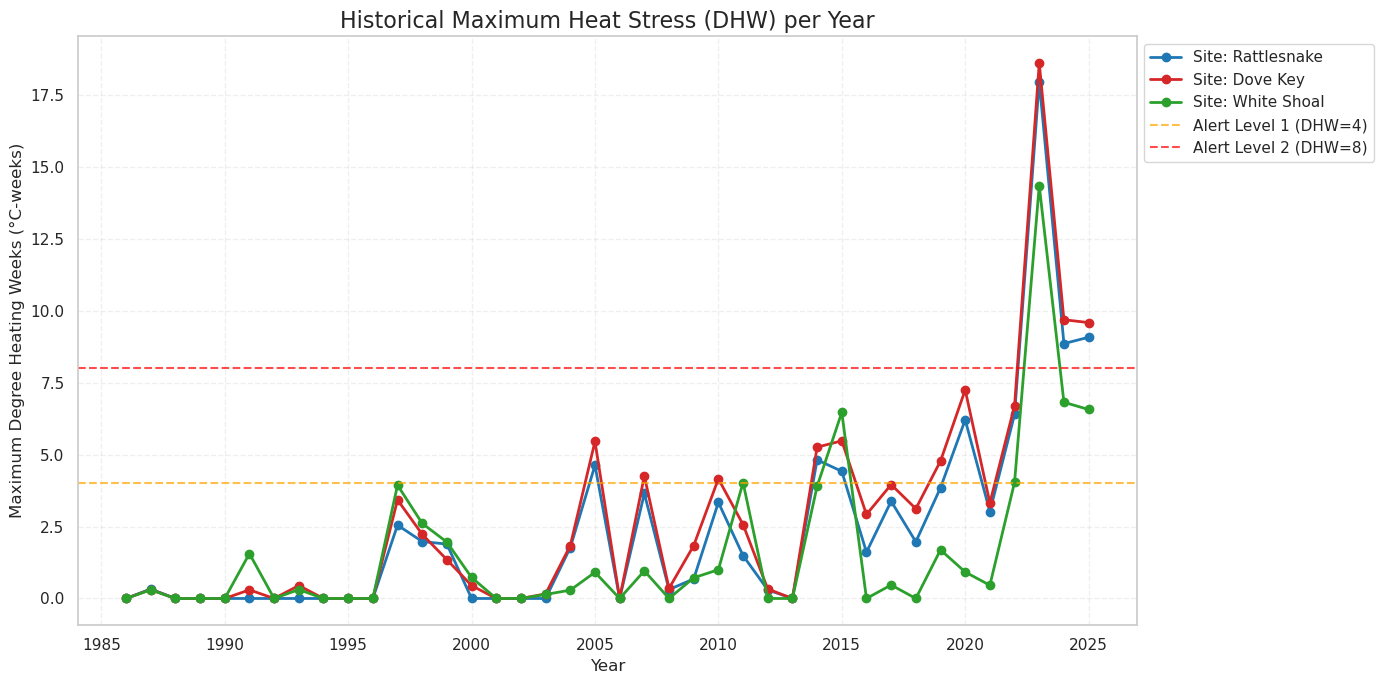

In [23]:
# 1. Load the merged DHW dataset
ds_dhw = xr.open_dataset("DHW_daily_merged_1986_2025.nc")

# 2. Prepare unique site list
df_unique_sites = df_stations[['Site_name', 'latDD', 'lonDD']].drop_duplicates(subset='Site_name')

site_dhw_results = {}

print(f"Extracting single-pixel DHW data for {len(df_unique_sites)} sites...")

for idx, row in df_unique_sites.iterrows():
    site = row['Site_name']
    lat, lon = row['latDD'], row['lonDD']
    
    # Extract single nearest pixel time series
    # Using .sel with method='nearest' handles the coordinate lookup
    # We select the 'dhw' variable (renamed during the merge step)
    subset = ds_dhw.dhw.sel(latitude=lat, longitude=lon, method='nearest')
    
    # Convert to dataframe
    # For DHW, we often want the raw daily data to identify peaks
    df_site = subset.to_dataframe().reset_index()
    df_site = df_site.rename(columns={'dhw': 'DHW_Value', 'time': 'Date'})
    df_site['Site_name'] = site
    
    # Calculate Annual Maximum DHW (The key bleaching stress metric)
    df_site['Year'] = pd.to_datetime(df_site['Date']).dt.year
    annual_max = df_site.groupby('Year')['DHW_Value'].max().reset_index()
    annual_max['Site_name'] = site
    
    site_dhw_results[site] = {
        'daily': df_site,
        'annual_max': annual_max
    }

# Combine all annual maxima into one master table
df_dhw_annual_master = pd.concat([res['annual_max'] for res in site_dhw_results.values()], ignore_index=True)

print("Extraction complete.")
display(df_dhw_annual_master.head())

# 3. Plotting Annual Maximum DHW for selected sites
selected_sites = ['Rattlesnake', 'Dove Key', 'White Shoal']
colors = {'Rattlesnake': '#1f77b4', 'Dove Key': '#d62728', 'White Shoal': '#2ca02c'}

plt.figure(figsize=(14, 7))

for site in selected_sites:
    data = site_dhw_results[site]['annual_max']
    plt.plot(data['Year'], data['DHW_Value'], marker='o', label=f'Site: {site}', color=colors[site], linewidth=2)

# Add NOAA Bleaching Thresholds
plt.axhline(4, color='orange', linestyle='--', alpha=0.7, label='Alert Level 1 (DHW=4)')
plt.axhline(8, color='red', linestyle='--', alpha=0.7, label='Alert Level 2 (DHW=8)')

# Formatting
plt.title('Historical Maximum Heat Stress (DHW) per Year', fontsize=16)
plt.ylabel('Maximum Degree Heating Weeks (°C-weeks)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Heat stress frequency maps: number of years each site has reached Alert Level 1 and Alert Level 2 (DHW >= 4 and DHW >= 8)

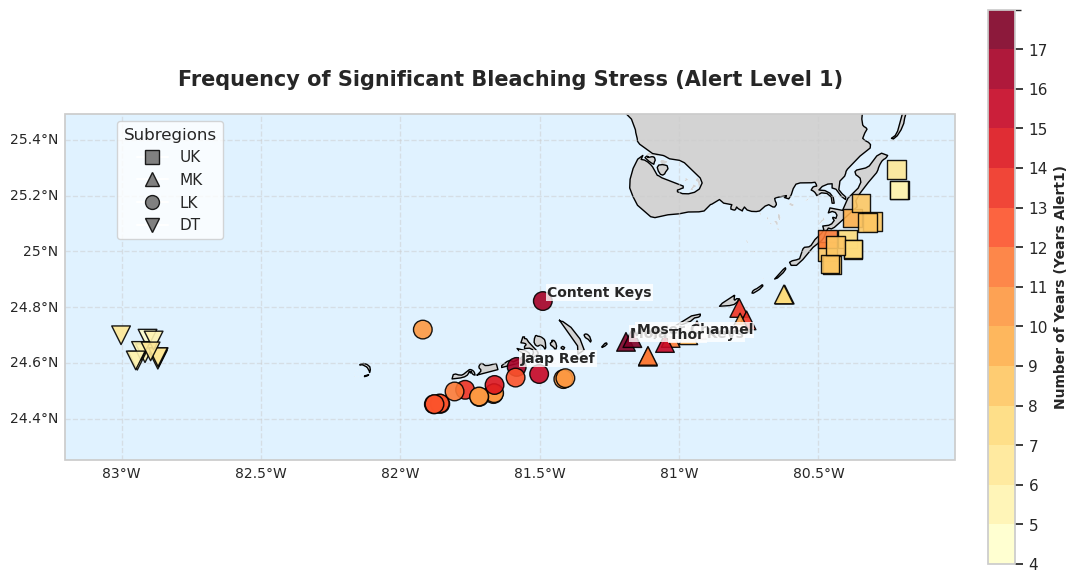

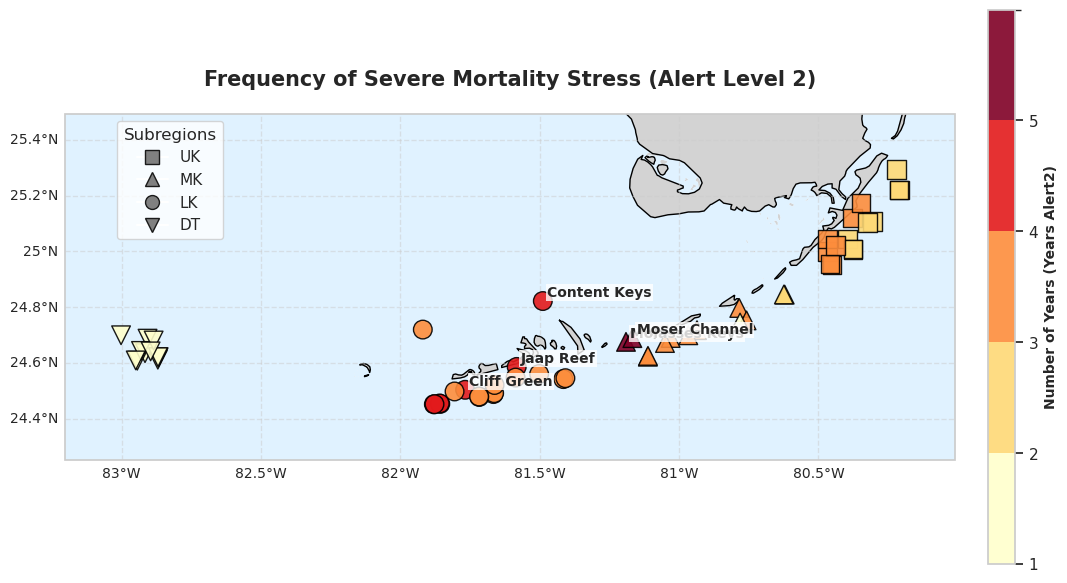

/tmp/ipykernel_1207842/3310621008.py:93: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_melted, x='Subregion', y='Years', hue='Alert_Level',


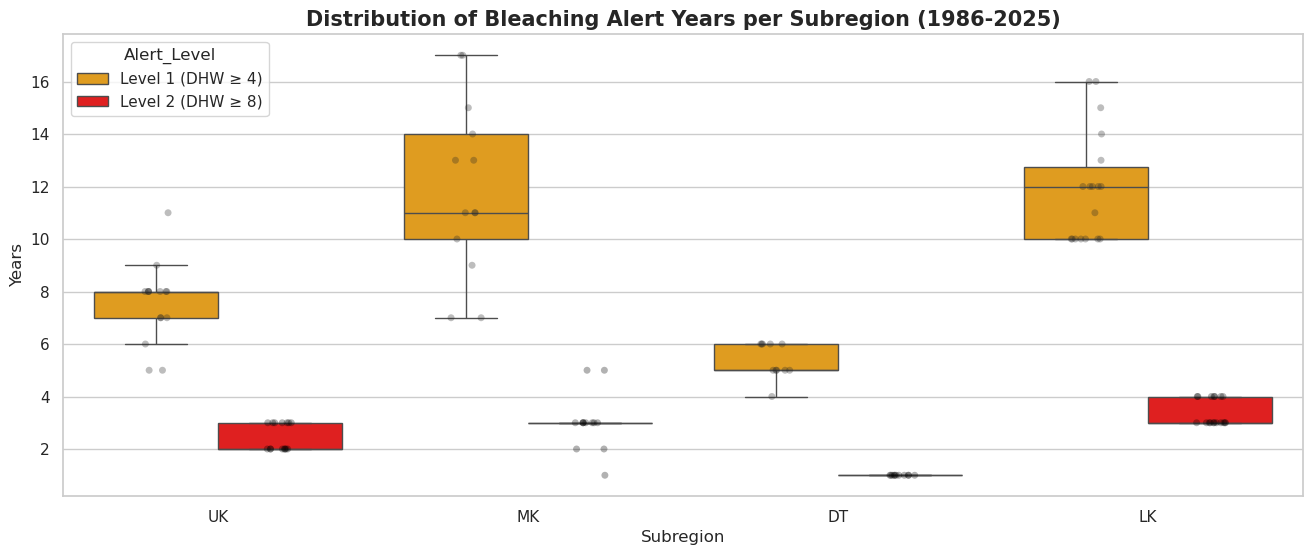

In [38]:
# --- 1. REGENERATE df_map_freq FROM df_dhw_annual_master ---
# We calculate how many years each site hit the DHW thresholds
df_map_freq = df_dhw_annual_master.groupby('Site_name').agg(
    years_alert1=('DHW_Value', lambda x: (x >= 4).sum()),
    years_alert2=('DHW_Value', lambda x: (x >= 8).sum())
).reset_index()

# --- 2. CLEAN AND MERGE METADATA (Coords + Subregion) ---
# Ensure we have a clean coordinate and subregion lookup from df_stations
df_meta_lookup = df_stations[['Site_name', 'latDD', 'lonDD', 'Subregion']].drop_duplicates(subset='Site_name')

# Merge metadata into our frequency results
df_map_freq = pd.merge(df_map_freq, df_meta_lookup, on='Site_name', how='left')

# --- 3. DEFINE MAPPING FUNCTION ---
def plot_categorical_dhw_map(data, column, title, cmap_name, label_n=5):
    plt.figure(figsize=(14, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set extent based on merged coordinates
    ax.set_extent([data['lonDD'].min() - 0.2, data['lonDD'].max() + 0.2,
                  data['latDD'].min() - 0.2, data['latDD'].max() + 0.2])
    
    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')
    
    # Discrete Color Map setup
    min_val, max_val = int(data[column].min()), int(data[column].max())
    n_colors = max_val - min_val + 1
    cmap = plt.get_cmap(cmap_name, n_colors)
    norm = mcolors.BoundaryNorm(np.arange(min_val, max_val + 2), cmap.N)

    # Marker logic for Subregions
    marker_map = {'UK': 's', 'MK': '^', 'LK': 'o', 'DT': 'v'}
    sc = None

    for sub, mkr in marker_map.items():
        sub_data = data[data['Subregion'] == sub]
        if not sub_data.empty:
            sc = ax.scatter(sub_data['lonDD'], sub_data['latDD'], 
                            c=sub_data[column], cmap=cmap, norm=norm,
                            marker=mkr, s=180, edgecolor='black', alpha=0.9, 
                            transform=ccrs.PlateCarree(), zorder=3)

    # Colorbar
    if sc:
        cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.6, 
                            ticks=np.arange(min_val, max_val + 1))
        cbar.set_label(f'Number of Years ({column.replace("_", " ").title()})', fontsize=10, fontweight='bold')
    
    # Legend for Subregions
    legend_elements = [Line2D([0], [0], marker=m, color='w', label=k,
                              markerfacecolor='gray', markersize=10, markeredgecolor='k') 
                       for k, m in marker_map.items()]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.05, 1), 
              title="Subregions", frameon=True)

    # Top Sites labels
    top_sites = data.nlargest(label_n, column)
    for idx, row in top_sites.iterrows():
        ax.text(row['lonDD'] + 0.015, row['latDD'] + 0.015, row['Site_name'],
                 transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1), zorder=4)

    # Adjust gridlines line 
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    plt.title(title, fontsize=15, fontweight='bold', pad=20)
    plt.show()

# --- 4. EXECUTION ---
plot_categorical_dhw_map(df_map_freq, 'years_alert1', 
                         'Frequency of Significant Bleaching Stress (Alert Level 1)', 'YlOrRd')

plot_categorical_dhw_map(df_map_freq, 'years_alert2', 
                         'Frequency of Severe Mortality Stress (Alert Level 2)', 'YlOrRd')

# --- 5. BOX PLOTS ---
plt.figure(figsize=(16, 6))
df_melted = df_map_freq.melt(id_vars=['Subregion'], 
                            value_vars=['years_alert1', 'years_alert2'],
                            var_name='Alert_Level', value_name='Years')
df_melted['Alert_Level'] = df_melted['Alert_Level'].map({'years_alert1': 'Level 1 (DHW ≥ 4)', 
                                                       'years_alert2': 'Level 2 (DHW ≥ 8)'})

sns.boxplot(data=df_melted, x='Subregion', y='Years', hue='Alert_Level', 
            palette={'Level 1 (DHW ≥ 4)': 'orange', 'Level 2 (DHW ≥ 8)': 'red'}, showfliers=False)
sns.stripplot(data=df_melted, x='Subregion', y='Years', hue='Alert_Level', 
              dodge=True, color='black', alpha=0.3, legend=False)
plt.title('Distribution of Bleaching Alert Years per Subregion (1986-2025)', fontsize=15, fontweight='bold')
plt.show()